<a href="https://colab.research.google.com/github/Carlos1971Salud/2021-Dengue-Fever-Prediction-Time-Series/blob/master/PASO_2_SINTAXIS_PRONOISTICO_IQUITOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [150]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv

In [151]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    plt.figure(figsize=(10, 6))
    if type(y) is tuple:
        for y_curr in y:
            plt.plot(x[start:end], y_curr[start:end], format)
    else:
        plt.plot(x[start:end], y[start:end], format)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend:
        plt.legend(legend)
    plt.title(title)
    plt.grid(True)

**2. Get DATA**
Take Data from Upstream (Local, Gdrive, Github, etc).

**Data Visualize**

In [152]:
import pandas as pd

# Load the dataset
data = pd.read_csv('/content/modelo_iquitos_dengue.csv', index_col='fecha', parse_dates=True)

# Filter the data to include only 'ubigeo' 160101
data = data[data['ubigeo'] == 160101]

# Display the first few rows
display(data.head())

ano  semana  ubigeo  CASOS departamento provincia distrito  \
fecha                                                                     
2016-01-04  2016       1  160101      7       LORETO    MAYNAS  IQUITOS   
2016-01-11  2016       2  160101      9       LORETO    MAYNAS  IQUITOS   
2016-01-18  2016       3  160101      4       LORETO    MAYNAS  IQUITOS   
2016-01-25  2016       4  160101      8       LORETO    MAYNAS  IQUITOS   
2016-02-01  2016       5  160101     18       LORETO    MAYNAS  IQUITOS   

            tmean  tmax  tmin  humr   ptot  
fecha                                       
2016-01-04   26.9  31.1  24.3  89.8   59.9  
2016-01-11   28.8  33.2  25.6  82.1    6.6  
2016-01-18   27.0  30.5  24.9  89.6   37.6  
2016-01-25   27.5  31.9  24.9  86.8   46.4  
2016-02-01   26.8  30.9  24.2  88.9  108.2

In [153]:
time = data.index
series = data['CASOS']

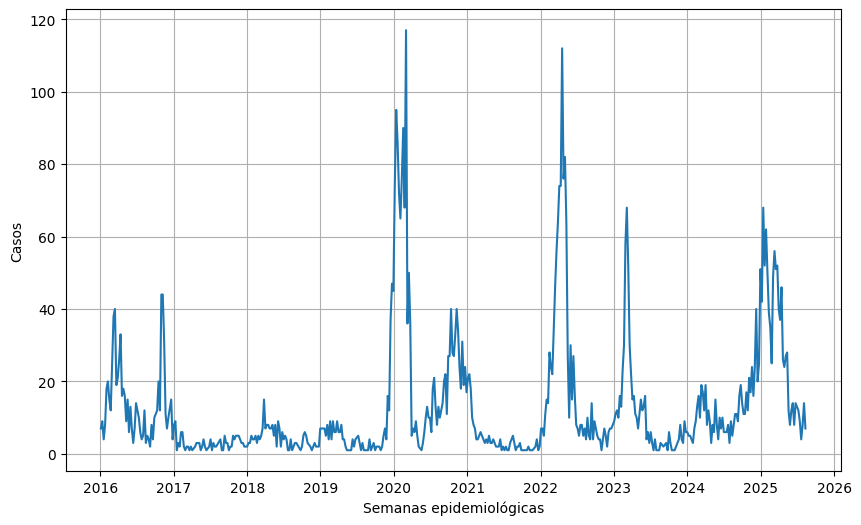

In [154]:
plot_series(time, series, xlabel='Semanas epidemiológicas', ylabel='Casos')

**3. Data Prerocessing**

Analysis and Cleaning Data -> Extract, Transform, Load.

Split Data

In [155]:
split_time = int(len(time)*0.7)
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

**Prepare Features and Labels**

In [156]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
window_size = 7
batch_size = 32
shuffle_buffer_size = 1000
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

**4. Model Architechture**

Using library from Scikit-learn, Tensorflow(?).

**RNN Model**

In [157]:
model_RNN = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=64, kernel_size=3,
strides=1,
activation="relu",
padding='causal',
input_shape=[window_size, 1]),
tf.keras.layers.SimpleRNN(64, return_sequences=True),
tf.keras.layers.SimpleRNN(64),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x: x * 100)
])
model_RNN.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 7, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 7, 64)          │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,833 (65.75 KB)

 Trainable params: 16,833 (65.75 KB)

 Non-trainable params: 0 (0.00 B)

**LSTM Model**

In [158]:
model_LSTM = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=64, kernel_size=3,
strides=1,
activation="relu",
padding='causal',
input_shape=[window_size, 1]),
tf.keras.layers.LSTM(64, return_sequences=True),
tf.keras.layers.LSTM(64),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x: x * 100)
])
model_LSTM.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 7, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 7, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,369 (259.25 KB)

 Trainable params: 66,369 (259.25 KB)

 Non-trainable params: 0 (0.00 B)

In [159]:
model_GRU = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=64, kernel_size=3,
strides=1,
activation="relu",
padding='causal',
input_shape=[window_size, 1]),
tf.keras.layers.GRU(64, return_sequences=True),
tf.keras.layers.GRU(64),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x: x * 100)
])
model_GRU.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 7, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 7, 64)          │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,241 (196.25 KB)

 Trainable params: 50,241 (196.25 KB)

 Non-trainable params: 0 (0.00 B)

In [160]:
model_RNN_LSTM = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=64, kernel_size=3,
strides=1,
activation="relu",
padding='causal',
input_shape=[window_size, 1]),
tf.keras.layers.SimpleRNN(64, return_sequences=True),
tf.keras.layers.LSTM(64),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x: x * 100)
])
model_RNN_LSTM.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 7, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 7, 64)          │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,601 (162.50 KB)

 Trainable params: 41,601 (162.50 KB)

 Non-trainable params: 0 (0.00 B)

In [161]:
model_RNN_GRU = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=64, kernel_size=3,
strides=1,
activation="relu",
padding='causal',
input_shape=[window_size, 1]),
tf.keras.layers.SimpleRNN(64, return_sequences=True),
tf.keras.layers.GRU(64),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x: x * 100)
])
model_RNN_GRU.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 7, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 7, 64)          │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_4 (Lambda)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,537 (131.00 KB)

 Trainable params: 33,537 (131.00 KB)

 Non-trainable params: 0 (0.00 B)

In [162]:
model_LSTM_RNN = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=64, kernel_size=3,
strides=1,
activation="relu",
padding='causal',
input_shape=[window_size, 1]),
tf.keras.layers.LSTM(64, return_sequences=True),
tf.keras.layers.SimpleRNN(64),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x: x * 100)
])
model_LSTM_RNN.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 7, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 7, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_5 (Lambda)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,601 (162.50 KB)

 Trainable params: 41,601 (162.50 KB)

 Non-trainable params: 0 (0.00 B)

In [163]:
model_LSTM_GRU = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=64, kernel_size=3,
strides=1,
activation="relu",
padding='causal',
input_shape=[window_size, 1]),
tf.keras.layers.LSTM(64, return_sequences=True),
tf.keras.layers.GRU(64),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x: x * 100)
])
model_LSTM_GRU.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 7, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 7, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_6 (Lambda)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,305 (227.75 KB)

 Trainable params: 58,305 (227.75 KB)

 Non-trainable params: 0 (0.00 B)

In [164]:
model_GRU_RNN = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=64, kernel_size=3,
strides=1,
activation="relu",
padding='causal',
                       input_shape=[window_size, 1]),
tf.keras.layers.GRU(64, return_sequences=True),
tf.keras.layers.SimpleRNN(64),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x: x * 100)
])
model_GRU_RNN.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)               │ (None, 7, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 7, 64)          │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_7 (Lambda)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,537 (131.00 KB)

 Trainable params: 33,537 (131.00 KB)

 Non-trainable params: 0 (0.00 B)

In [165]:
model_GRU_LSTM = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=64, kernel_size=3,
strides=1,
activation="relu",
padding='causal',
input_shape=[window_size, 1]),
tf.keras.layers.GRU(64, return_sequences=True),
tf.keras.layers.LSTM(64),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x: x * 100)
])
model_GRU_LSTM .summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 7, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 7, 64)          │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_8 (Lambda)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,305 (227.75 KB)

 Trainable params: 58,305 (227.75 KB)

 Non-trainable params: 0 (0.00 B)

***4. Model Architechture***
Using library from Scikit-learn, Tensorflow(?).

**RNN Model**

In [166]:
model_RNN = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=64, kernel_size=3,
strides=1,
activation="relu",
padding='causal',
input_shape=[window_size, 1]),
tf.keras.layers.SimpleRNN(64, return_sequences=True),
tf.keras.layers.SimpleRNN(64),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x: x * 100)
])
model_RNN.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 7, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ (None, 7, 64)          │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_9 (Lambda)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,833 (65.75 KB)

 Trainable params: 16,833 (65.75 KB)

 Non-trainable params: 0 (0.00 B)

**LSTM Model**

In [167]:
model_LSTM = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=64, kernel_size=3,
strides=1,
activation="relu",
padding='causal',
input_shape=[window_size, 1]),
tf.keras.layers.LSTM(64, return_sequences=True),
tf.keras.layers.LSTM(64),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x: x * 100)
])
model_LSTM.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)              │ (None, 7, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 7, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_10 (Lambda)              │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,369 (259.25 KB)

 Trainable params: 66,369 (259.25 KB)

 Non-trainable params: 0 (0.00 B)

**GRU Model**

In [168]:
model_GRU = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=64, kernel_size=3,
strides=1,
activation="relu",
padding='causal',
input_shape=[window_size, 1]),
tf.keras.layers.GRU(64, return_sequences=True),
tf.keras.layers.GRU(64),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x: x * 100)
])
model_GRU.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_11 (Conv1D)              │ (None, 7, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ (None, 7, 64)          │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_11 (Lambda)              │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,241 (196.25 KB)

 Trainable params: 50,241 (196.25 KB)

 Non-trainable params: 0 (0.00 B)

**RNN-LSTM Model**

In [169]:
model_RNN_LSTM = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=64, kernel_size=3,
strides=1,
activation="relu",
padding='causal',
input_shape=[window_size, 1]),
tf.keras.layers.SimpleRNN(64, return_sequences=True),
tf.keras.layers.LSTM(64),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x: x * 100)
])
model_RNN_LSTM.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 7, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ (None, 7, 64)          │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_12 (Lambda)              │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,601 (162.50 KB)

 Trainable params: 41,601 (162.50 KB)

 Non-trainable params: 0 (0.00 B)

**RNN-GRU Model**

In [170]:
model_RNN_GRU = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=64, kernel_size=3,
strides=1,
activation="relu",
padding='causal',
input_shape=[window_size, 1]),
tf.keras.layers.SimpleRNN(64, return_sequences=True),
tf.keras.layers.GRU(64),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x: x * 100)
])
model_RNN_GRU.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_13 (Conv1D)              │ (None, 7, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_9 (SimpleRNN)        │ (None, 7, 64)          │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_8 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_13 (Lambda)              │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,537 (131.00 KB)

 Trainable params: 33,537 (131.00 KB)

 Non-trainable params: 0 (0.00 B)

**LSTM-RNN**

In [171]:
model_LSTM_RNN = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=64, kernel_size=3,
strides=1,
activation="relu",
padding='causal',
input_shape=[window_size, 1]),
tf.keras.layers.LSTM(64, return_sequences=True),
tf.keras.layers.SimpleRNN(64),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x: x * 100)
])
model_LSTM_RNN.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)              │ (None, 7, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 7, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_10 (SimpleRNN)       │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_14 (Lambda)              │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,601 (162.50 KB)

 Trainable params: 41,601 (162.50 KB)

 Non-trainable params: 0 (0.00 B)

**LSTM-GRU Model**

In [172]:
model_LSTM_GRU = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=64, kernel_size=3,
strides=1,
activation="relu",
padding='causal',
input_shape=[window_size, 1]),
tf.keras.layers.LSTM(64, return_sequences=True),
tf.keras.layers.GRU(64),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x: x * 100)
])
model_LSTM_GRU.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)              │ (None, 7, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 7, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_9 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_15 (Lambda)              │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,305 (227.75 KB)

 Trainable params: 58,305 (227.75 KB)

 Non-trainable params: 0 (0.00 B)

**GRU-RNN Model**

In [173]:
model_GRU_RNN = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=64, kernel_size=3,
strides=1,
activation="relu",
padding='causal',
                       input_shape=[window_size, 1]),
tf.keras.layers.GRU(64, return_sequences=True),
tf.keras.layers.SimpleRNN(64),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x: x * 100)
])
model_GRU_RNN.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_16 (Conv1D)              │ (None, 7, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_10 (GRU)                    │ (None, 7, 64)          │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_11 (SimpleRNN)       │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_16 (Lambda)              │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,537 (131.00 KB)

 Trainable params: 33,537 (131.00 KB)

 Non-trainable params: 0 (0.00 B)

**GRU-LSTM Model**

In [174]:
model_GRU_LSTM = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=64, kernel_size=3,
strides=1,
activation="relu",
padding='causal',
input_shape=[window_size, 1]),
tf.keras.layers.GRU(64, return_sequences=True),
tf.keras.layers.LSTM(64),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x: x * 100)
])
model_GRU_LSTM .summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_17 (Conv1D)              │ (None, 7, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_11 (GRU)                    │ (None, 7, 64)          │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_17 (Lambda)              │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,305 (227.75 KB)

 Trainable params: 58,305 (227.75 KB)

 Non-trainable params: 0 (0.00 B)

**5. Model Training**

In [175]:
tf.keras.backend.clear_session()
learning_rate = 8e-7

In [176]:
optimizer_RNN = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
model_RNN.compile(loss=tf.keras.losses.Huber(),
optimizer=optimizer_RNN,
metrics=["mae", "mse", "mape"])
history_RNN = model_RNN.fit(train_set,epochs=100)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 33.0350 - mae: 33.5330 - mape: 1052.3655 - mse: 1608.1039
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 18.6905 - mae: 19.1789 - mape: 508.3823 - mse: 599.6140
Epoch 3/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 14.5943 - mae: 15.0888 - mape: 433.7552 - mse: 449.1038
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 11.3582 - mae: 11.8423 - mape: 318.7217 - mse: 290.6110
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 11.2259 - mae: 11.7118 - mape: 304.9916 - mse: 298.7262
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 11.4431 - mae: 11.9336 - mape: 301.3641 - mse: 347.0395
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 10.8618 - mae: 11.3540 - mape: 252.8859 - mse: 310.5909
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 10.6369 - mae: 11.1280 - mape: 255.1190 - mse: 275.6659
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.2497 - mae: 9.7343 - mape: 222.8548 - mse: 196.8175
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.9813 - mae: 9.4671 - mape: 219.0415 - mse: 223.6996
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.5878 - mae: 9.0717 - mape: 

In [177]:
optimizer_LSTM = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
model_LSTM.compile(loss=tf.keras.losses.Huber(),
optimizer=optimizer_LSTM,
metrics=["mae", "mse", "mape"])
history_LSTM = model_LSTM.fit(train_set,epochs=100)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 7.3807 - mae: 7.8484 - mape: 92.0535 - mse: 275.0245
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.9848 - mae: 8.4593 - mape: 100.2775 - mse: 303.3174
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.6725 - mae: 8.1354 - mape: 91.2432 - mse: 301.3095
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.8315 - mae: 8.2945 - mape: 87.9391 - mse: 297.3199
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.3892 - mae: 8.8473 - mape: 83.6111 - mse: 327.6112
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.9904 - mae: 7.4429 - mape: 82.2955 - mse: 231.6625
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.0066 - mae: 7.4687 - mape: 81.8492 - mse: 244.9394
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.5873 - mae: 6.0380 - mape: 74.1300 - mse: 158.2838
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.1649 - mae: 7.6264 - mape: 82.378

In [178]:
optimizer_GRU= tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
model_GRU.compile(loss=tf.keras.losses.Huber(),
optimizer=optimizer_GRU,
metrics=["mae", "mse", "mape"])
history_GRU = model_GRU.fit(train_set,epochs=100)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 44.8432 - mae: 45.3426 - mape: 522.0768 - mse: 4142.7275
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 27.6371 - mae: 28.1270 - mape: 299.2781 - mse: 2274.8142
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 23.5132 - mae: 24.0099 - mape: 451.7751 - mse: 1324.2059
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 19.5277 - mae: 20.0263 - mape: 456.0590 - mse: 810.4925
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.0719 - mae: 18.5703 - mape: 324.4635 - mse: 816.2018
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 15.9280 - mae: 16.4241 - mape: 248.9663 - mse: 846.6027
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 12.3150 - mae: 12.8073 - mape: 183.2358 - mse: 500.2639
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.3649 - mae: 9.8511 - mape: 154.0573 - mse: 319.4868
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.5472 - ma

In [179]:
optimizer_RNN_LSTM = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
model_RNN_LSTM.compile(loss=tf.keras.losses.Huber(),
optimizer=optimizer_RNN_LSTM,
metrics=["mae", "mse", "mape"])
history_RNN_LSTM = model_RNN_LSTM.fit(train_set,epochs=100)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 50.7558 - mae: 51.2558 - mape: 1438.4144 - mse: 2846.2812
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 37.9677 - mae: 38.4677 - mape: 1119.2477 - mse: 1625.8521
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 18.0728 - mae: 18.5694 - mape: 487.2013 - mse: 484.5667
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.9817 - mae: 9.4542 - mape: 159.3827 - mse: 300.8582
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.1058 - mae: 9.5885 - mape: 170.1843 - mse: 286.0567
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.2912 - mae: 8.7710 - mape: 148.5149 - mse: 241.5810
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.7295 - mae: 8.2140 - mape: 140.4568 - mse: 239.1988
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.9237 - mae: 8.4066 - mape: 134.1737 - mse: 266.5482
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.1777 - mae: 7.6627 - mape

In [180]:
optimizer_RNN_GRU = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
model_RNN_GRU.compile(loss=tf.keras.losses.Huber(),
optimizer=optimizer_RNN_GRU,
metrics=["mae", "mse", "mape"])
history_RNN_GRU = model_RNN_GRU.fit(train_set,epochs=100)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 58.8284 - mae: 59.3283 - mape: 1750.8965 - mse: 3984.8208
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 32.6884 - mae: 33.1865 - mape: 960.6902 - mse: 1418.8074 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 15.4738 - mae: 15.9676 - mape: 338.6266 - mse: 560.7468
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 14.0062 - mae: 14.4990 - mape: 311.7682 - mse: 466.9273
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 13.3184 - mae: 13.8124 - mape: 316.8228 - mse: 385.3408
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 11.4440 - mae: 11.9354 - mape: 285.1729 - mse: 275.2181
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 11.6862 - mae: 12.1806 - mape: 263.7996 - mse: 343.5603
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 11.0424 - mae: 11.5346 - mape: 260.5166 - mse: 323.4803
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.6179 - mae: 10.

In [181]:
optimizer_LSTM_RNN = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
model_LSTM_RNN.compile(loss=tf.keras.losses.Huber(),
optimizer=optimizer_LSTM_RNN,
metrics=["mae", "mse", "mape"])
history_LSTM_RNN = model_LSTM_RNN.fit(train_set,epochs=100)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 36.1032 - mae: 36.6025 - mape: 1221.1621 - mse: 1752.8090
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 22.4801 - mae: 22.9742 - mape: 514.3569 - mse: 993.3644 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11.3534 - mae: 11.8489 - mape: 286.3827 - mse: 225.4084
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.4877 - mae: 9.9769 - mape: 263.8035 - mse: 165.2214 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.5590 - mae: 9.0475 - mape: 215.6946 - mse: 143.5553
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.8699 - mae: 8.3566 - mape: 216.3250 - mse: 121.9544
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.1273 - mae: 8.6066 - mape: 196.8021 - mse: 139.0840
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.3452 - mae: 7.8301 - mape: 191.1877 - mse: 110.9727
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.3453 - mae: 7.8301 - mape

In [182]:
optimizer_LSTM_GRU = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
model_LSTM_GRU.compile(loss=tf.keras.losses.Huber(),
optimizer=optimizer_LSTM_GRU,
metrics=["mae", "mse", "mape"])
history_LSTM_GRU = model_LSTM_GRU.fit(train_set,epochs=100)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 11.2169 - mae: 11.7100 - mape: 171.4769 - mse: 515.4659
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.9152 - mae: 9.4023 - mape: 154.3076 - mse: 295.4987 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.2913 - mae: 6.7623 - mape: 108.3699 - mse: 197.6857
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.1488 - mae: 7.6034 - mape: 69.1540 - mse: 239.3295
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.3793 - mae: 6.8463 - mape: 77.1862 - mse: 202.5425
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.8048 - mae: 7.2691 - mape: 73.6787 - mse: 210.5280
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.7843 - mae: 6.2388 - mape: 67.2196 - mse: 147.1407
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.4824 - mae: 5.9382 - mape: 66.1452 - mse: 139.3597
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.7241 - mae: 6.1847 - mape: 6

In [183]:
optimizer_GRU_RNN= tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
model_GRU_RNN.compile(loss=tf.keras.losses.Huber(),
optimizer=optimizer_GRU_RNN,
metrics=["mae", "mse", "mape"])
history_GRU_RNN = model_GRU_RNN.fit(train_set,epochs=100)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 98.9894 - mae: 99.4893 - mape: 1579.9528 - mse: 15516.1914
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 56.4960 - mae: 56.9953 - mape: 885.2365 - mse: 5907.0908
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 33.2351 - mae: 33.7350 - mape: 966.6472 - mse: 1662.8420
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 27.8954 - mae: 28.3912 - mape: 1156.0781 - mse: 1181.0127
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 19.2817 - mae: 19.7768 - mape: 687.0170 - mse: 648.7321
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 15.9015 - mae: 16.3985 - mape: 495.9241 - mse: 417.9329
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 14.5651 - mae: 15.0594 - mape: 417.7108 - mse: 352.5676
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 12.3476 - mae: 12.8426 - mape: 373.6089 - mse: 270.0916
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11.0087 - mae:

In [184]:
optimizer_GRU_LSTM= tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
model_GRU_LSTM.compile(loss=tf.keras.losses.Huber(),
optimizer=optimizer_GRU_LSTM,
metrics=["mae", "mse", "mape"])
history_GRU_LSTM = model_GRU_LSTM.fit(train_set,epochs=100)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 6.4268 - mae: 6.8928 - mape: 69.2734 - mse: 189.4454
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.9822 - mae: 7.4575 - mape: 95.2482 - mse: 226.3578
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.2742 - mae: 6.7393 - mape: 78.4063 - mse: 167.3749
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.2686 - mae: 5.7232 - mape: 62.6095 - mse: 116.3171
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 5.3816 - mae: 5.8362 - mape: 66.7795 - mse: 125.5474
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.9525 - mae: 5.4082 - mape: 70.8093 - mse: 109.9847
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.3408 - mae: 5.7947 - mape: 65.2023 - mse: 127.2939
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.6845 - mae: 6.1398 - mape: 65.4986 - mse: 132.6661
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.9014 - mae: 6.3552 - mape: 63.8184

**6. Model Evaluation**

Loss evaluation using Scatter Plot

In [185]:
# Plot Function
def visualize_evaluation(history):
    mae=history.history['mae']
    loss=history.history['loss']

    epochs=range(len(loss))

    plot_series(
        x=epochs,
        y=(mae, loss),
        title='MAE y Loss',
        xlabel='Epochs',
        ylabel='Sunspot',
        legend=['MAE', 'Loss'])

    zoom_split = int(epochs[-1] * 0.2)
    epochs_zoom = epochs[zoom_split:]
    mae_zoom = mae[zoom_split:]
    loss_zoom = loss[zoom_split:]

    plot_series(
        x=epochs_zoom,
        y=(mae_zoom, loss_zoom),
        title='MAE y Loss (Last 80%)',
        xlabel='Epochs',
        ylabel='Sunspot',
        legend=['MAE', 'Loss'])

**RNN Evaluation**

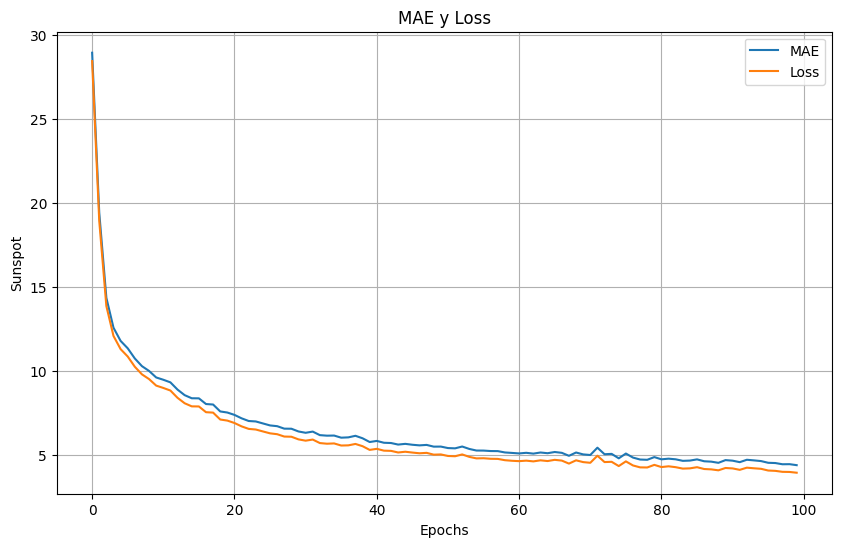

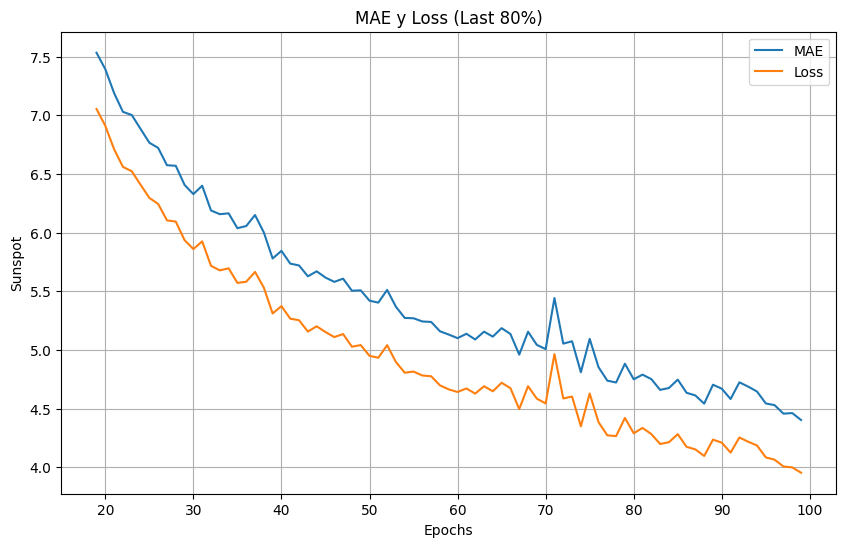

In [186]:
visualize_evaluation(history_RNN)

**LSTM Evaluation**

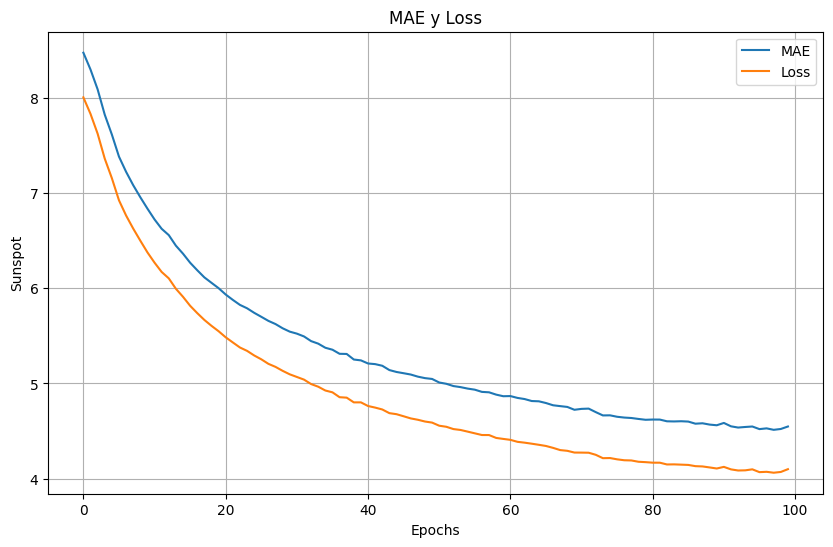

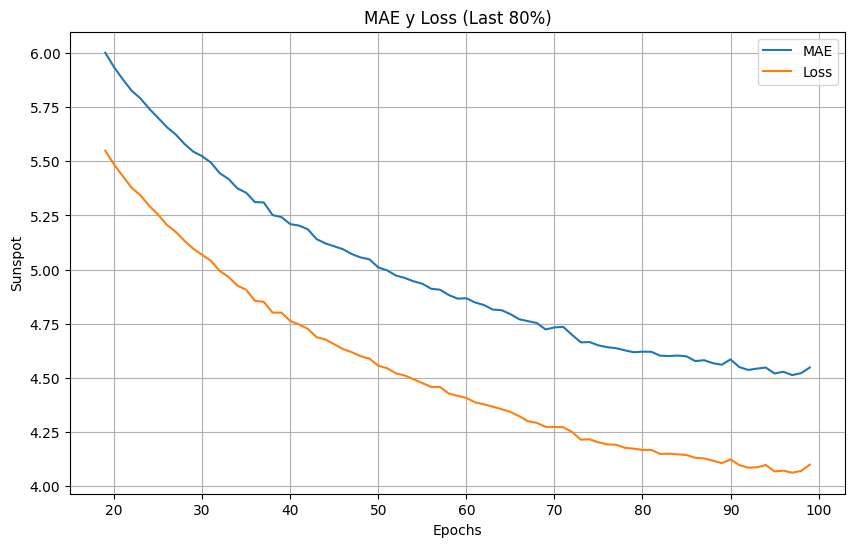

In [187]:
visualize_evaluation(history_LSTM)

**GRU Evaluation**

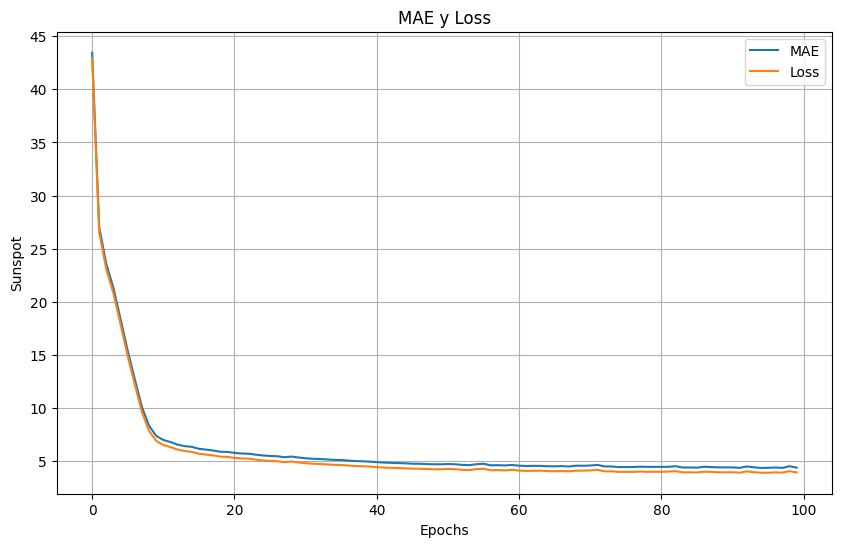

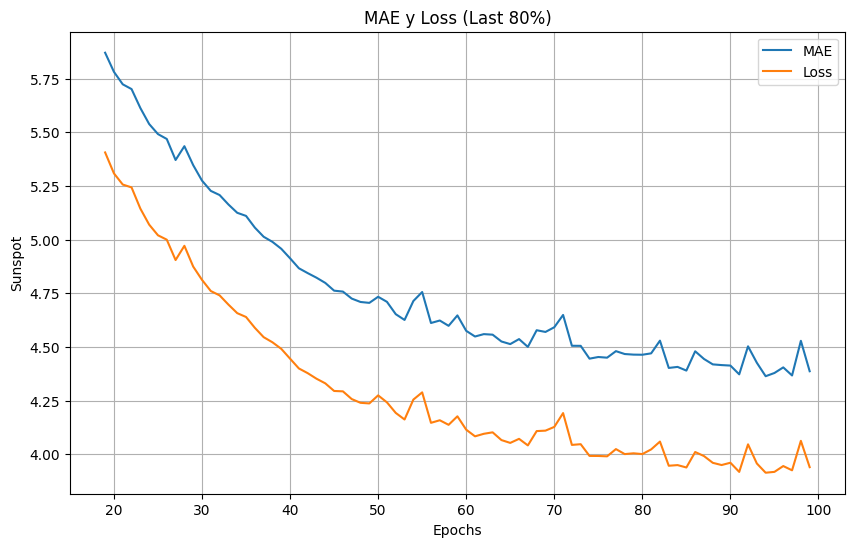

In [188]:
visualize_evaluation(history_GRU)

**RNN-LSTM Evaluation**

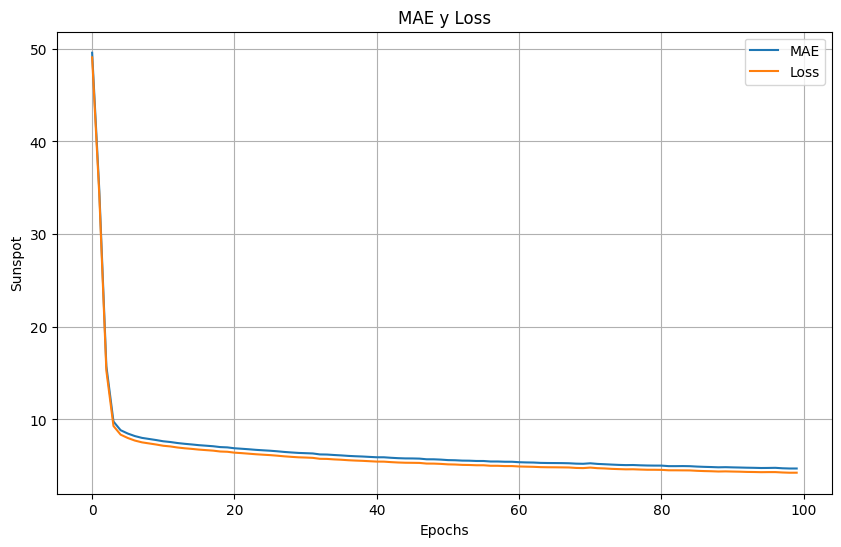

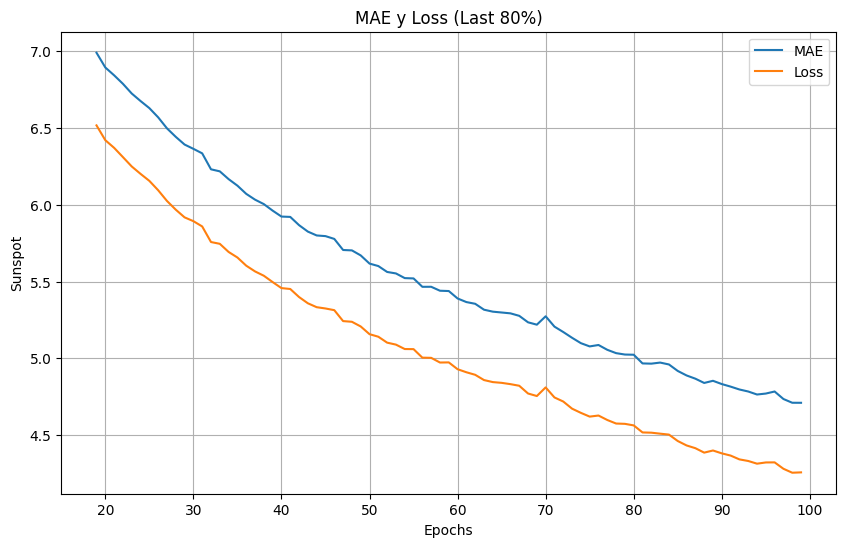

In [189]:
visualize_evaluation(history_RNN_LSTM)

**RNN-GRU Evaluation**

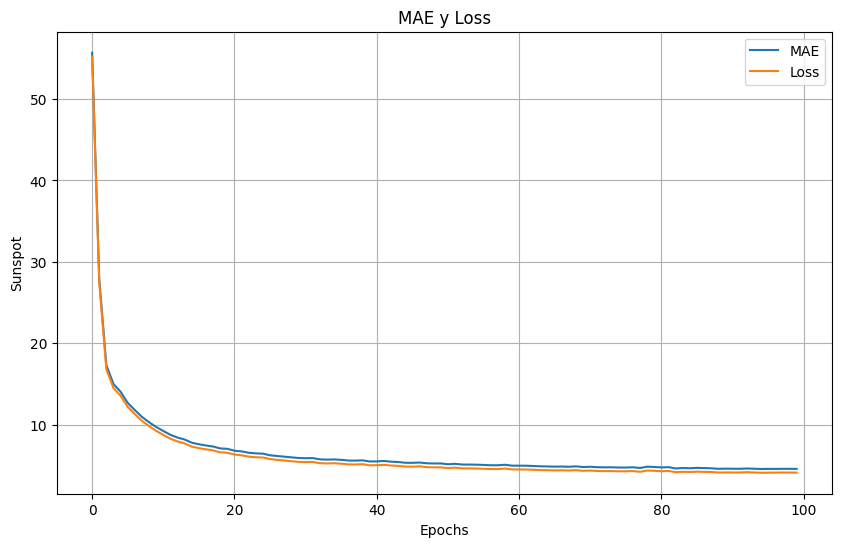

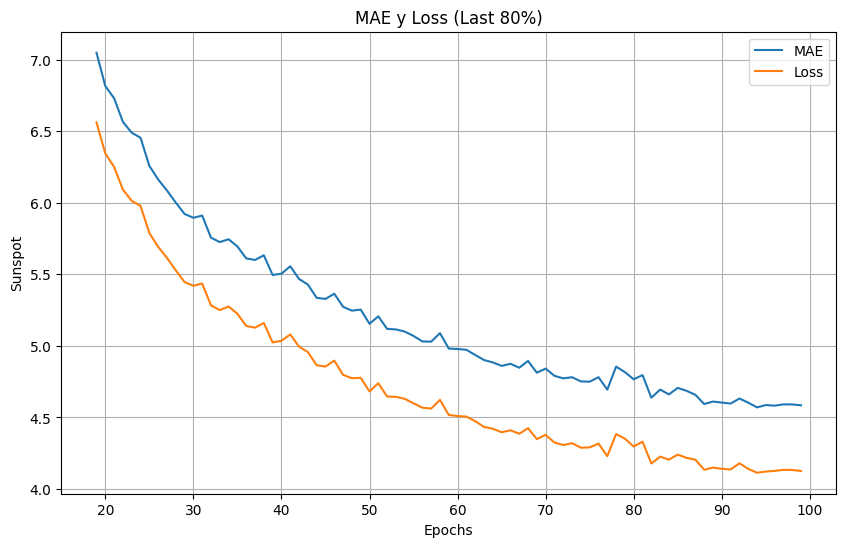

In [190]:
visualize_evaluation(history_RNN_GRU)

**LSTM-RNN Evaluation**

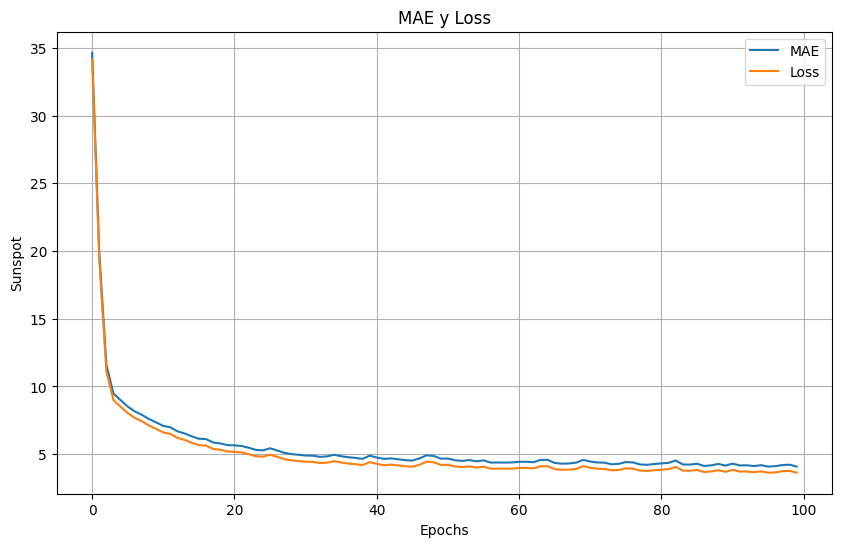

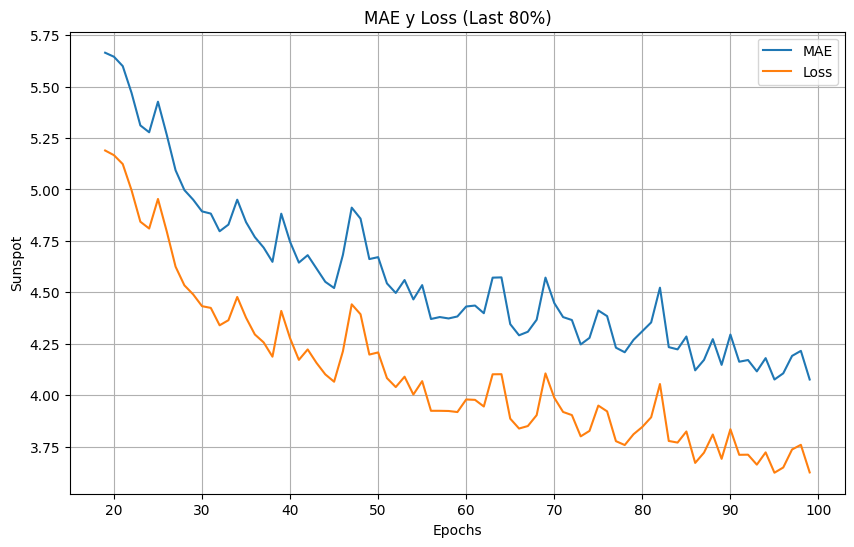

In [191]:
visualize_evaluation(history_LSTM_RNN)

**LSTM-GRU Evaluation**

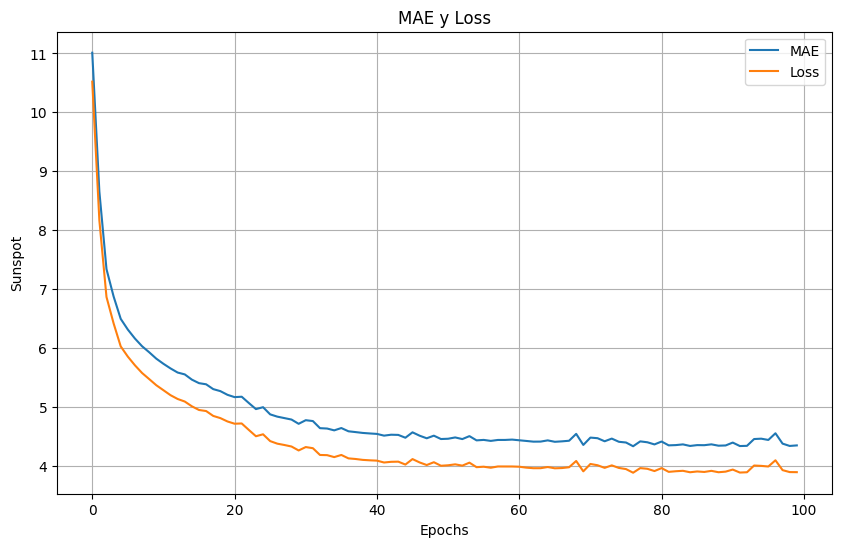

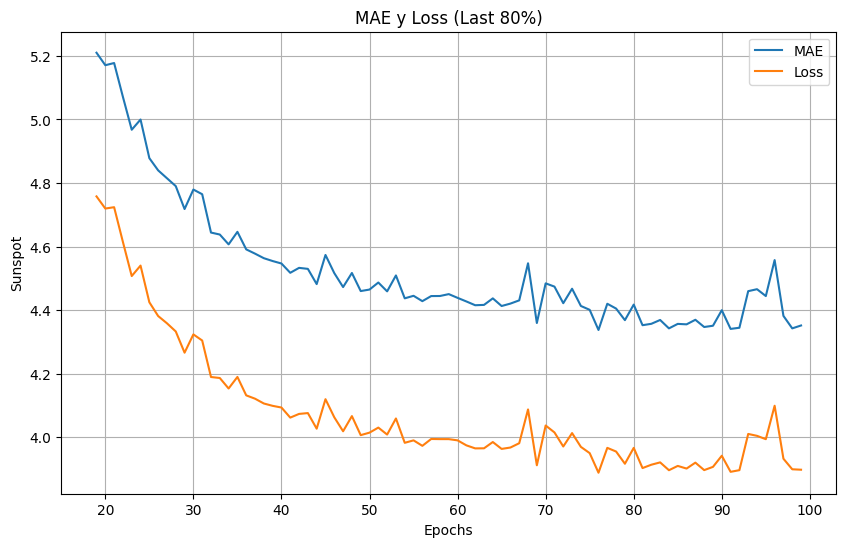

In [192]:
visualize_evaluation(history_LSTM_GRU)

**GRU-RNN Evaluation**

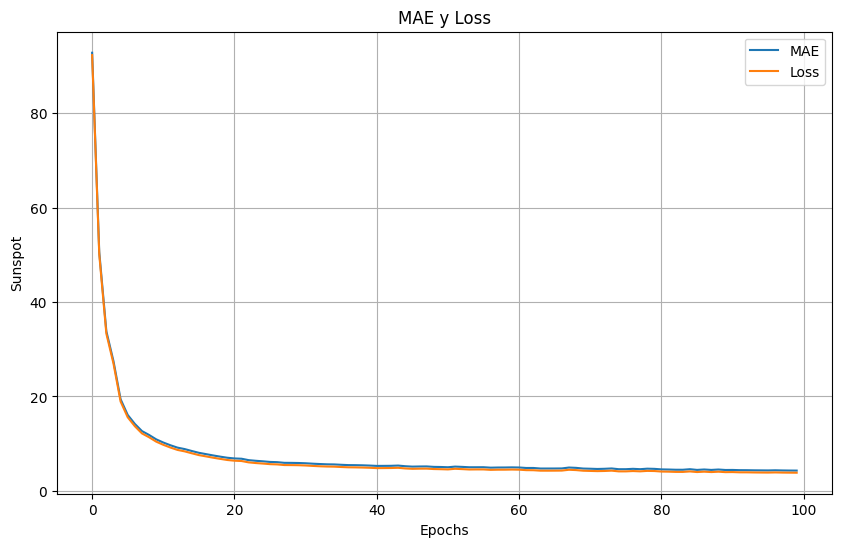

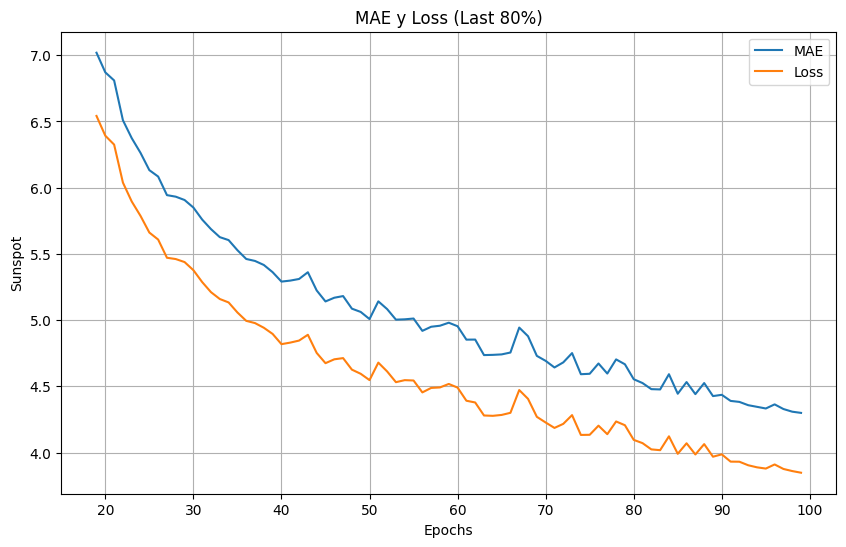

In [193]:
visualize_evaluation(history_GRU_RNN)

**GRU-LSTM Evaluation**

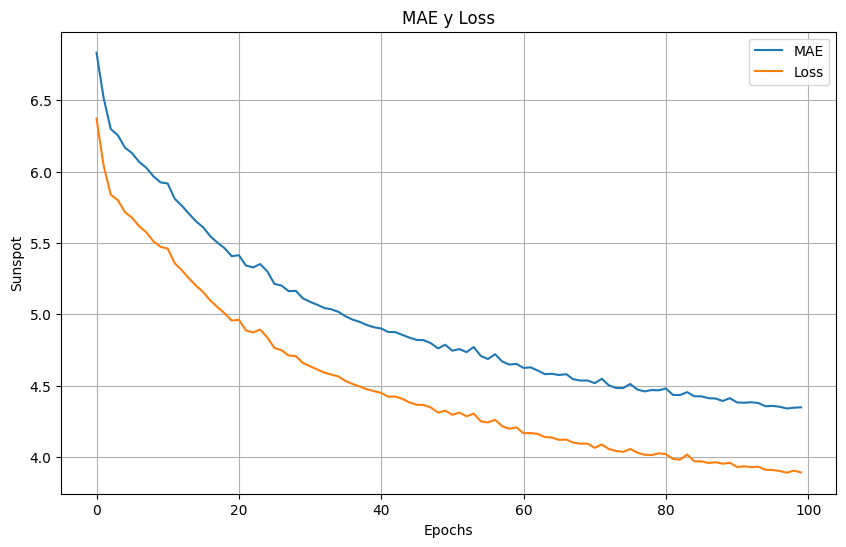

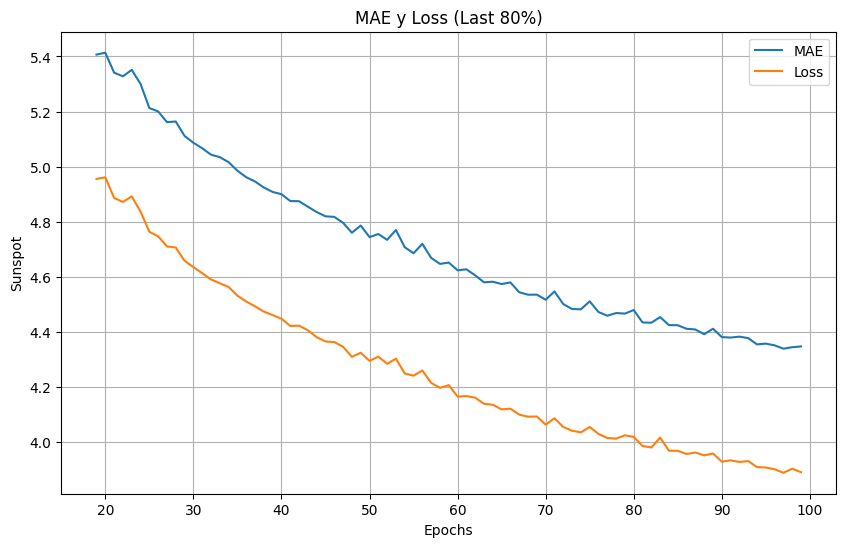

In [194]:
visualize_evaluation(history_GRU_LSTM)

**GRU-LSTM Evaluation**

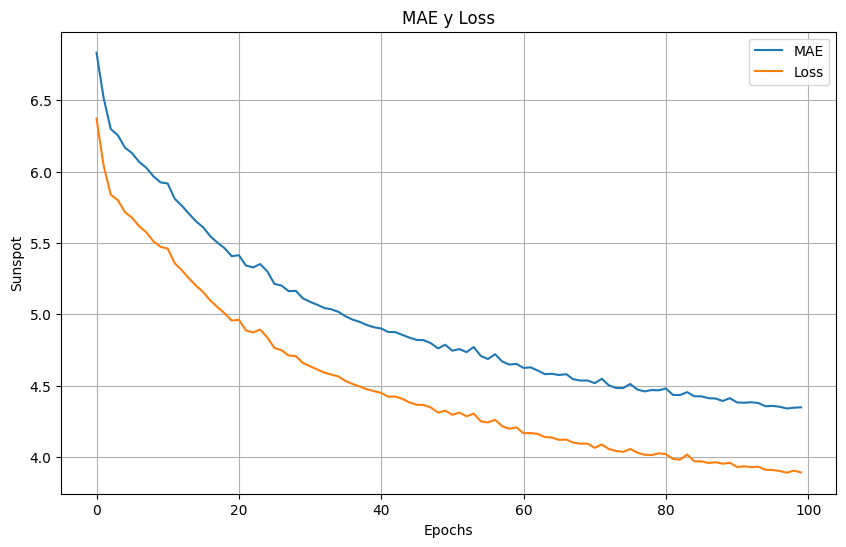

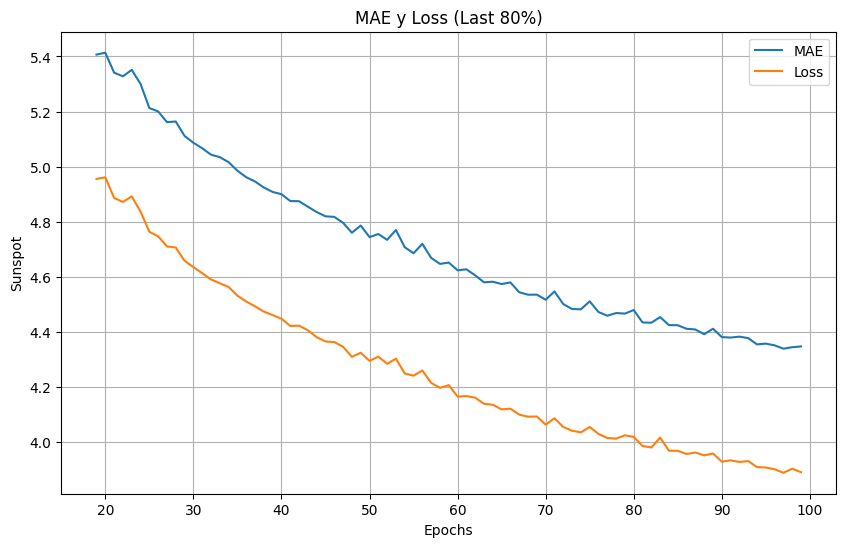

In [195]:
visualize_evaluation(history_GRU_LSTM)

**7. Model Prediction**

**Analysis outcome of clustering for whale transaction characteristic**

In [302]:
def model_forecast(model, series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset.repeat(1)) # Add .repeat(1) to prevent warning
    return forecast

In [303]:
def predict(model):
    forecast_series = series[split_time-window_size:-1]
    forecast = model_forecast(model, forecast_series, window_size, batch_size)
    results = forecast.squeeze()
    plot_series(time_valid, (x_valid, results, ), title='Resultados pronósticados',
                xlabel='Semanas epidemiológicas',
                ylabel='Casos',
                legend=['Valor pronosticado', 'Valor actual'])

**RNN Prediction**

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


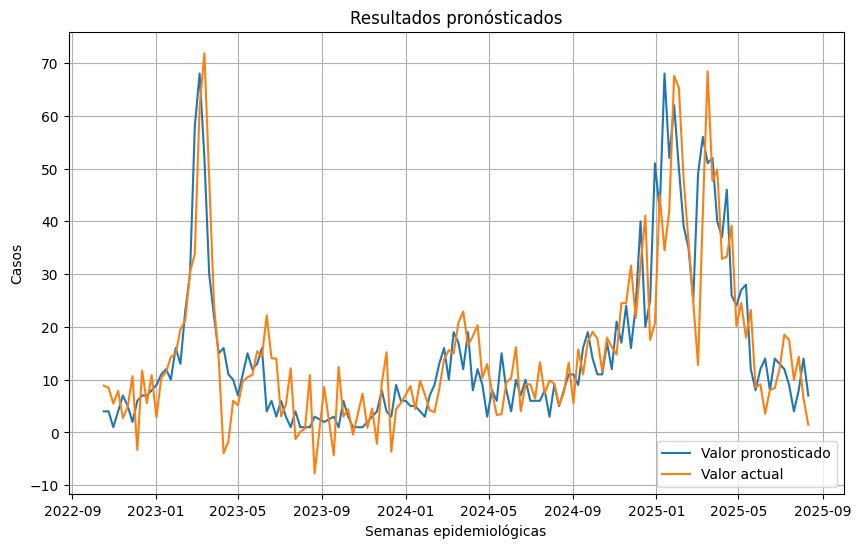

In [255]:
predict(model_RNN)

**LSTM Prediction**

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


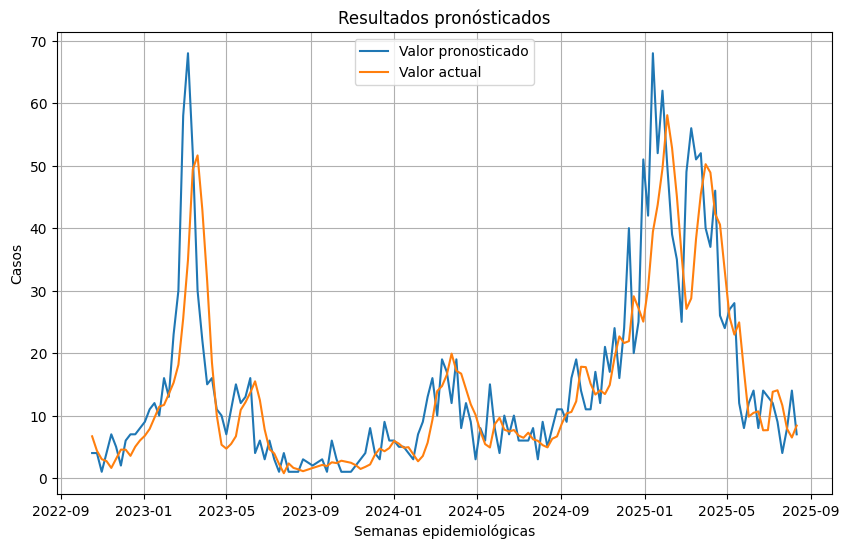

In [256]:
predict(model_LSTM)

**GRU Prediction**

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


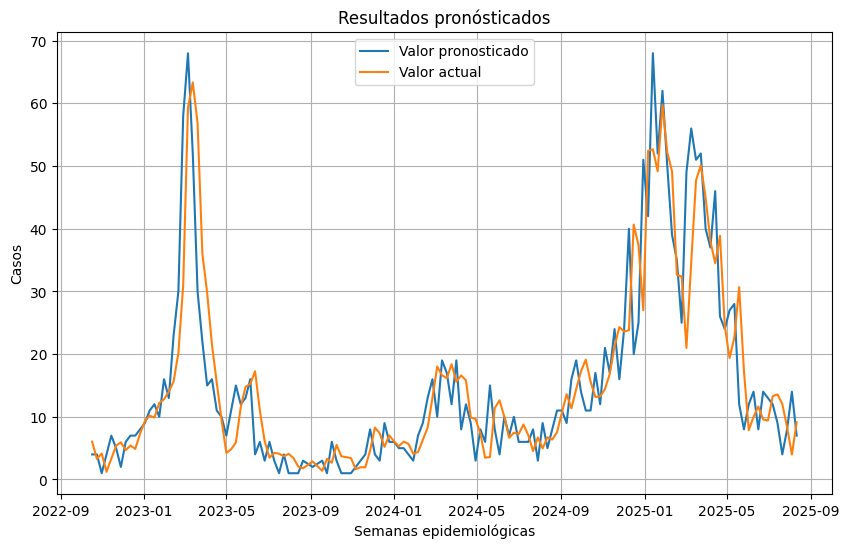

In [257]:
predict(model_GRU)

**RNN-LSTM Prediction**

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


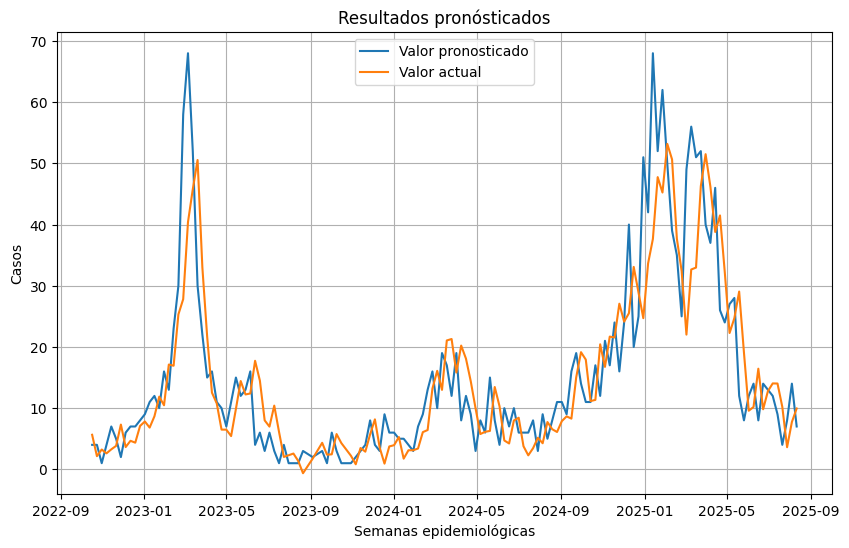

In [258]:
predict(model_RNN_LSTM)

**RNN-GRU Prediction**

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


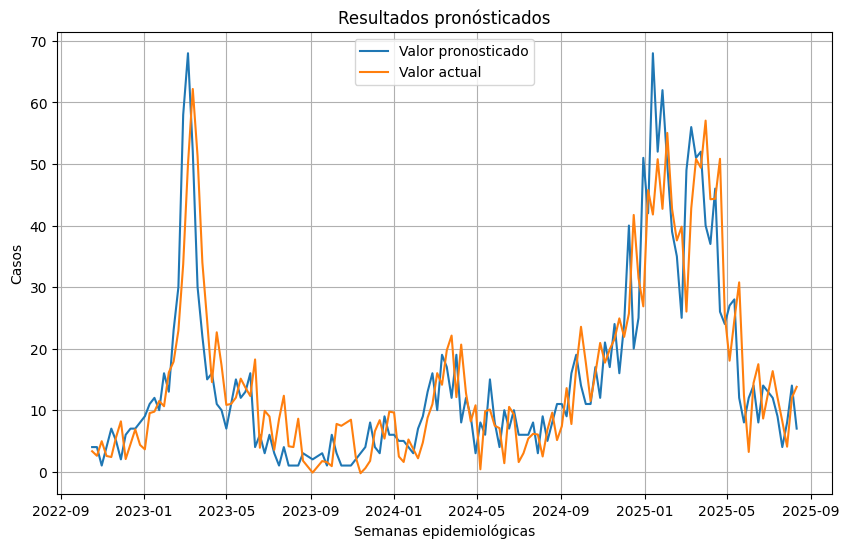

In [259]:
predict(model_RNN_GRU)

**LSTM-RNN Prediction**

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


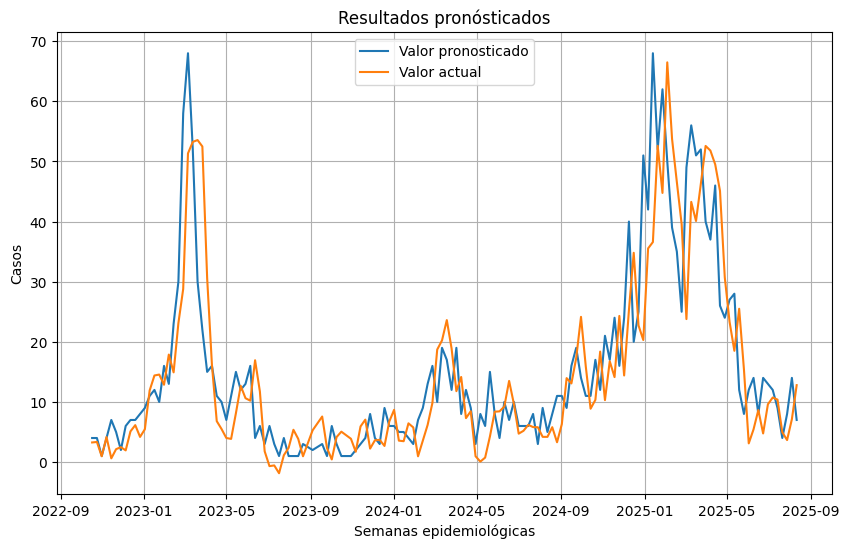

In [260]:
predict(model_LSTM_RNN)

**LSTM-GRU Prediction**

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


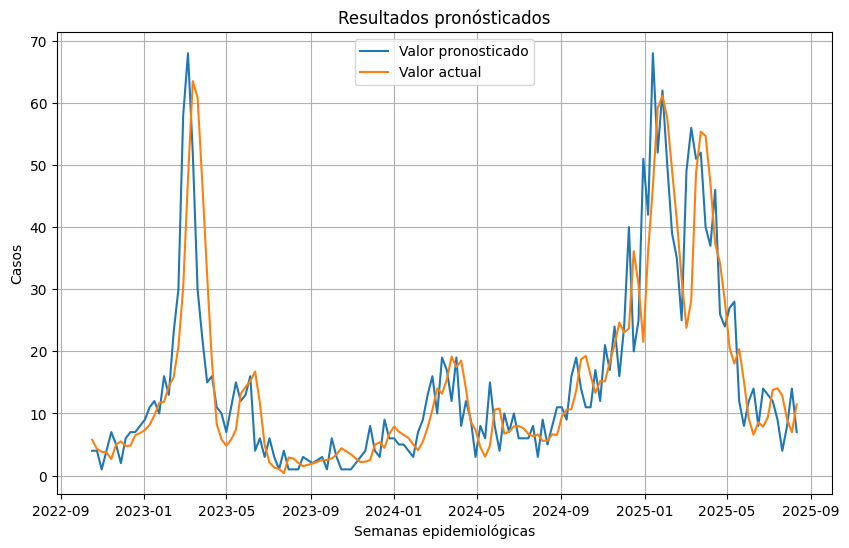

In [261]:
predict(model_LSTM_GRU)

**GRU-RNN Prediction**

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


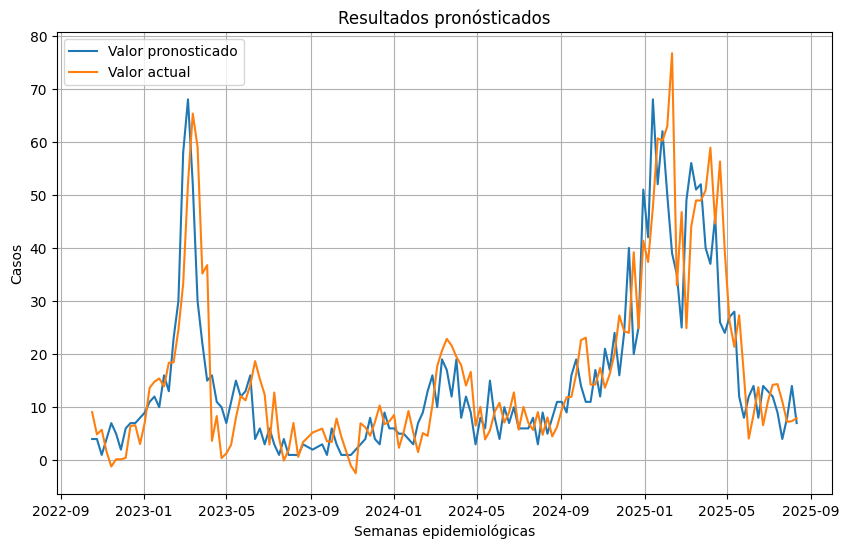

In [262]:
predict(model_GRU_RNN)

**GRU-LSTM Prediction**

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


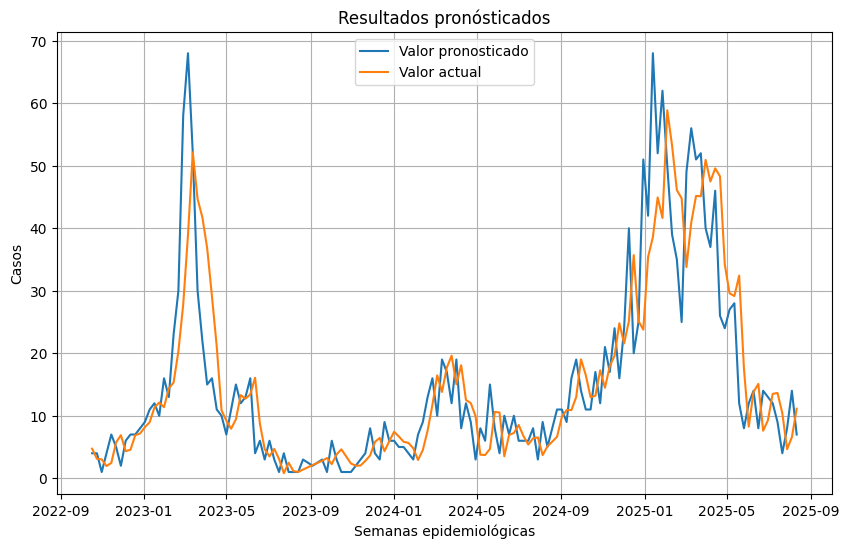

In [263]:
predict(model_GRU_LSTM)

**Confident Interval**

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


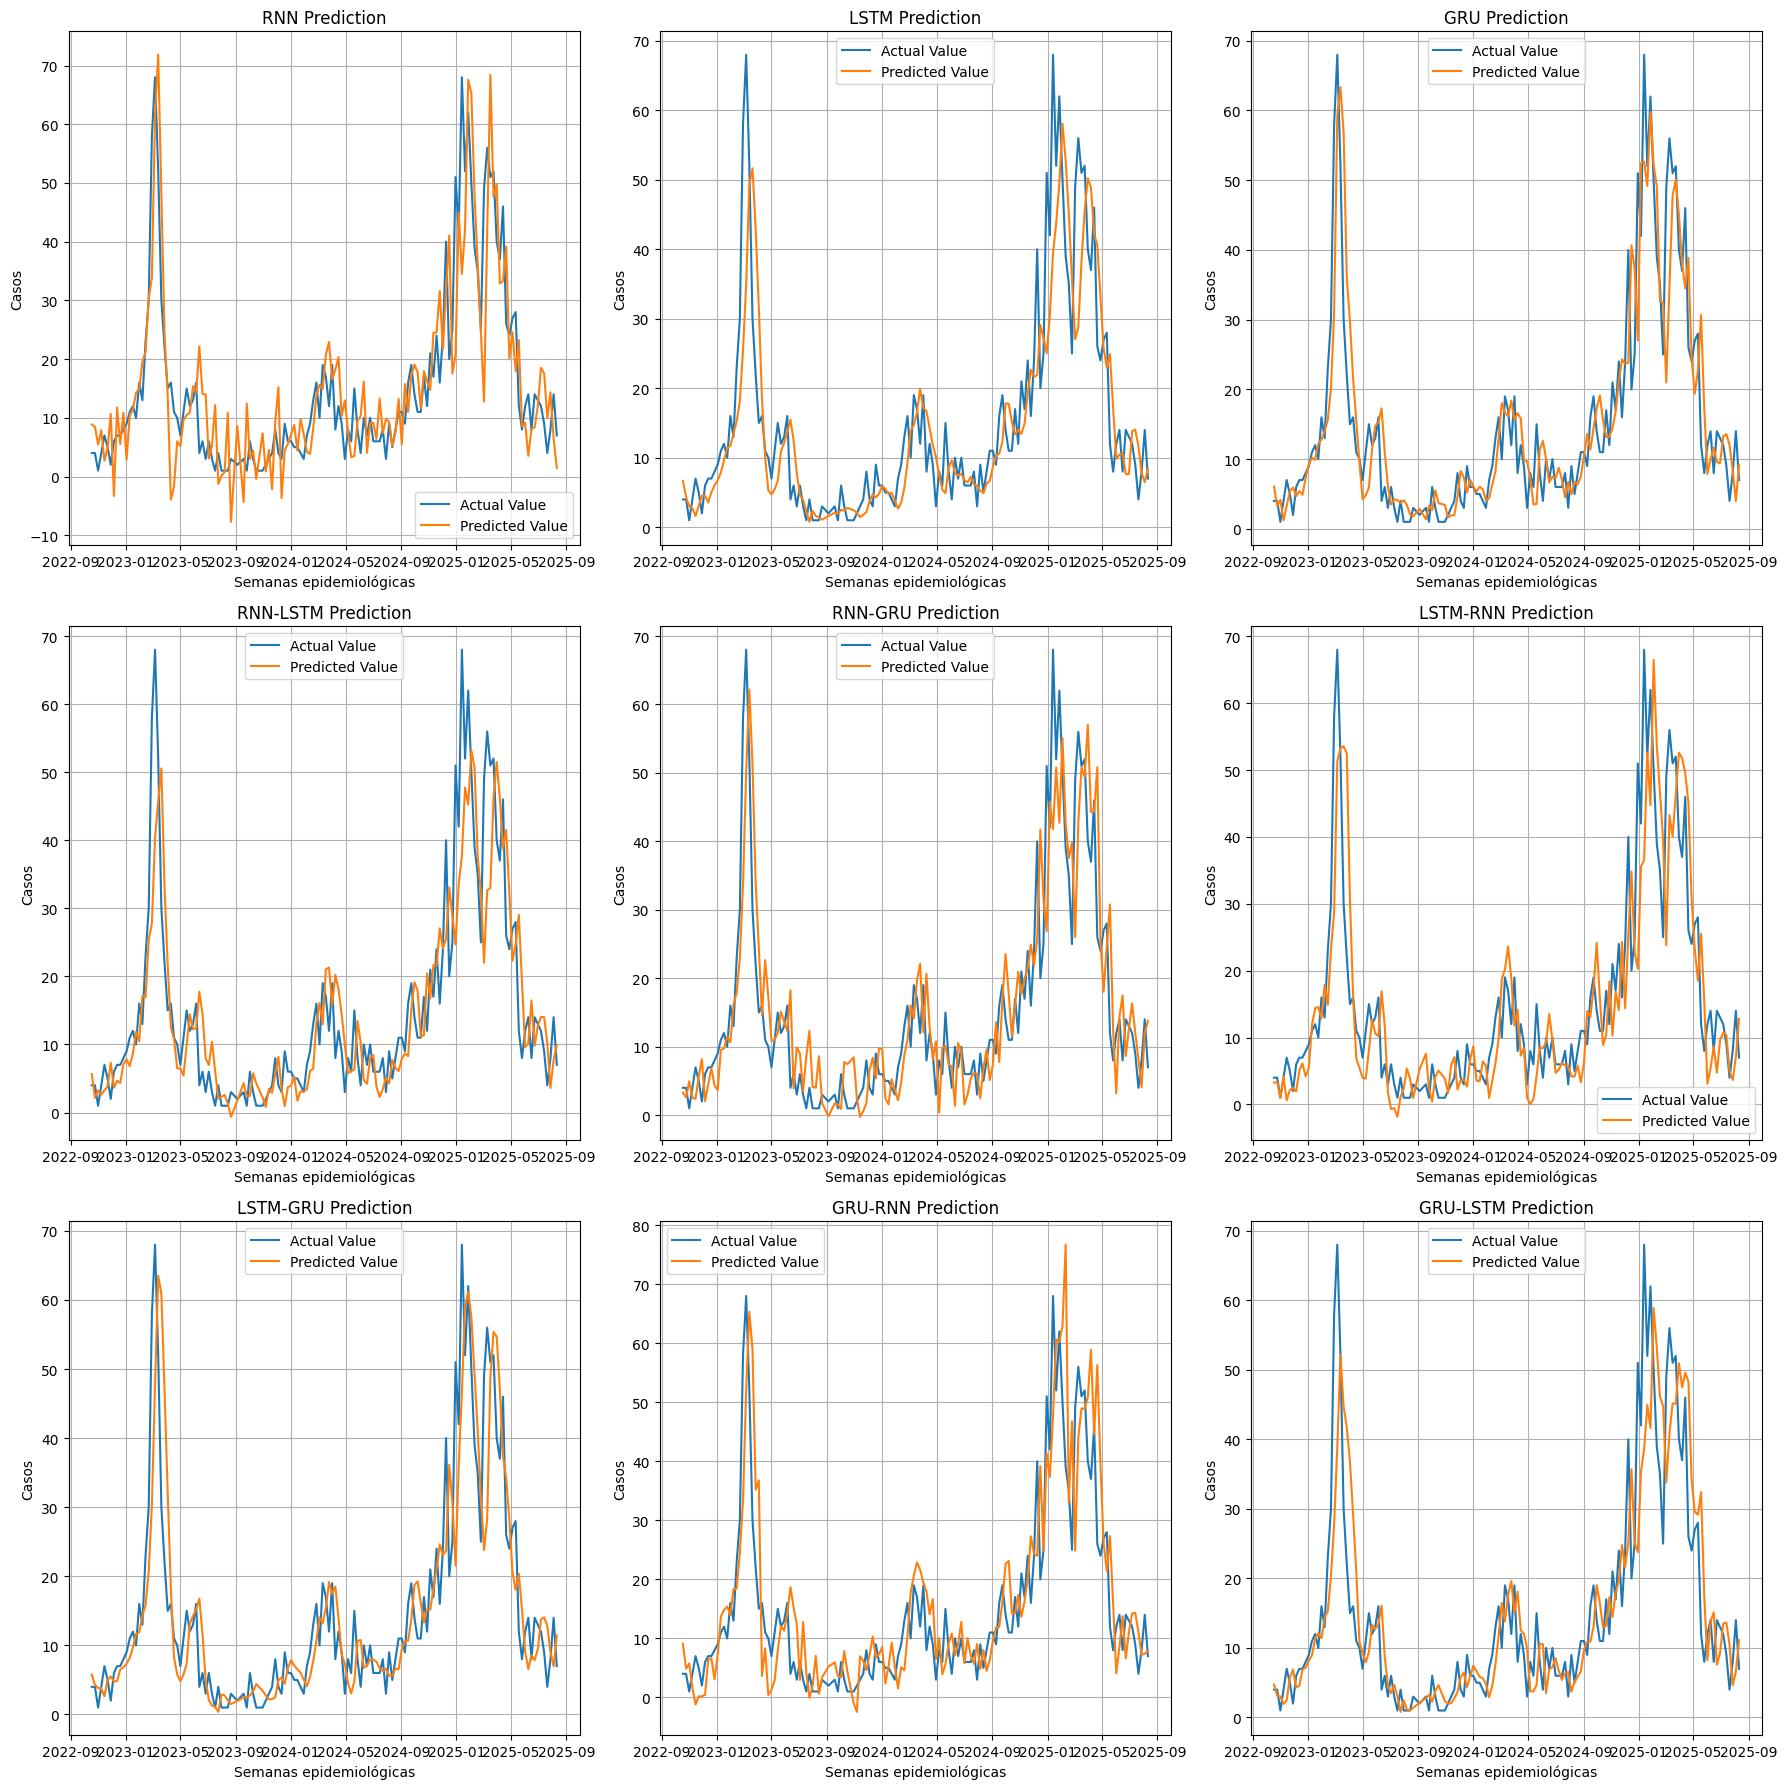

In [304]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
axes = axes.flatten()

models = {
    'RNN': model_RNN,
    'LSTM': model_LSTM,
    'GRU': model_GRU,
    'RNN-LSTM': model_RNN_LSTM,
    'RNN-GRU': model_RNN_GRU,
    'LSTM-RNN': model_LSTM_RNN,
    'LSTM-GRU': model_LSTM_GRU,
    'GRU-RNN': model_GRU_RNN,
    'GRU-LSTM': model_GRU_LSTM
}

for i, (name, model) in enumerate(models.items()):
    forecast_series = series[split_time - window_size:-1]
    forecast = model_forecast(model, forecast_series, window_size, batch_size)
    results = forecast.squeeze()

    axes[i].plot(time_valid, x_valid, label='Actual Value')
    axes[i].plot(time_valid, results, label='Predicted Value')
    axes[i].set_title(f'{name} Prediction')
    axes[i].set_xlabel('Semanas epidemiológicas')
    axes[i].set_ylabel('Casos')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()

In [207]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
import time

**Donwload Data**

In [208]:
!wget https://github.com/kkms51/data/raw/main/GRU_LSTM_TIME.xlsx
!wget https://github.com/kkms51/data/raw/main/GRU_RNN_TIME.xlsx
!wget https://github.com/kkms51/data/raw/main/GRU_TIME.xlsx
!wget https://github.com/kkms51/data/raw/main/LSTM_GRU_TIME.xlsx
!wget https://github.com/kkms51/data/raw/main/LSTM_RNN_TIME.xlsx
!wget https://github.com/kkms51/data/raw/main/RNN_LSTM_TIME.xlsx
!wget https://github.com/kkms51/data/raw/main/RNN_GRU_TIME.xlsx

--2025-09-25 02:02:07--  https://github.com/kkms51/data/raw/main/GRU_LSTM_TIME.xlsx
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-09-25 02:02:08 ERROR 404: Not Found.

--2025-09-25 02:02:08--  https://github.com/kkms51/data/raw/main/GRU_RNN_TIME.xlsx
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-09-25 02:02:09 ERROR 404: Not Found.

--2025-09-25 02:02:09--  https://github.com/kkms51/data/raw/main/GRU_TIME.xlsx
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-09-25 02:02:10 ERROR 404: Not Found.

--2025-09-25 02:02:10--  https://github.com/kkms51/data/raw/main/LSTM_GRU_TIME.xlsx
Resolving github.co

In [209]:
!wget https://drive.google.com/uc?id=1OusiKKuYGBZxP41JqALwjS5fiZ5bVET8 -O RNN_PREDICT.xlsx
!wget https://drive.google.com/uc?id=17Z12L9mQh91d7wz5tu2V4ywzrVJ91hRj -O RNN_LOSS.xlsx
!wget https://drive.google.com/uc?id=1sgrbiaGJrwF-AEXEr8R5x2Ulk95dq56K -O LSTM_PREDICT.xlsx
!wget https://drive.google.com/uc?id=11dDMmQ8RWVDHcZuNyEeWlC-k0nHx5pv4 -O LSTM_LOSS.xlsx
!wget https://drive.google.com/uc?id=1RCRBAGpTxkxruxc-XBDxBUq5A-eIS7RB -O GRU_PREDICT.xlsx
!wget https://drive.google.com/uc?id=1jzDhLE81rWPZffIwBg-MvuMqVPpg-bY- -O GRU_LOSS.xlsx
!wget https://drive.google.com/uc?id=1ar8H4y9QWquY6zM_cxpk3vp_aDy6gcjU -O RNN_GRU_PREDICT.xlsx
!wget https://drive.google.com/uc?id=1Lmaa9hUtdTD_OFdC4aRwfYxtMjjLWU7i -O RNN_GRU_LOSS.xlsx
!wget https://drive.google.com/uc?id=1Fg9-g0HfM6OPAIBetFllDdiHOQDU7_Pe -O LSTM_RNN_PREDICT.xlsx
!wget https://drive.google.com/uc?id=1uHwTBW5IhPG9cnnBN3P5vGAW0HlJEUfG -O LSTM_RNN_LOSS.xlsx
!wget https://drive.google.com/uc?id=1xOn5Jvk_5hzaLVbmCWMSulcEqPzJNm29 -O LSTM_GRU_PREDICT.xlsx
!wget https://drive.google.com/uc?id=1RkZQ50WhKxoCRswyMTEDp-Jpfbwm5six -O LSTM_GRU_LOSS.xlsx
!wget https://drive.google.com/uc?id=1-uCIfgqEUmM2EOiFb9v7iBVRL1kMMXj1 -O GRU_RNN_PREDICT.xlsx
!wget https://drive.google.com/uc?id=18hpQAoeUicSeYaJb0SKuHj-Op6LAHXrG -O GRU_RNN_LOSS.xlsx
!wget https://drive.google.com/uc?id=1gXJIGhIKKkPERaecvST5rX16lrnqGZ1j -O GRU_LSTM_PREDICT.xlsx
!wget https://drive.google.com/uc?id=1MGNVSDpfEerjj9fOlZI3LYkLxN6YHGiS -O GRU_LSTM_LOSS.xlsx

--2025-09-25 02:02:12--  https://drive.google.com/uc?id=1OusiKKuYGBZxP41JqALwjS5fiZ5bVET8
Resolving drive.google.com (drive.google.com)... 74.125.137.139, 74.125.137.113, 74.125.137.100, ...
Connecting to drive.google.com (drive.google.com)|74.125.137.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1OusiKKuYGBZxP41JqALwjS5fiZ5bVET8 [following]
--2025-09-25 02:02:12--  https://drive.usercontent.google.com/download?id=1OusiKKuYGBZxP41JqALwjS5fiZ5bVET8
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.101.132, 2607:f8b0:4023:c06::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.101.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 232199 (227K) [application/octet-stream]
Saving to: ‘RNN_PREDICT.xlsx’

RNN_PREDICT.xlsx    100%[===================>] 226.76K  --.-KB/s    in 0.06s   

2025-09-25 02:02:14 (3.56 MB

**Viz**

In [267]:
import matplotlib.pyplot as plt

from re import X
def shade_plot(temp, x_valid='0', line='MAE', predict=''):
    import matplotlib.pyplot as plt
    if predict == '':
        redline = f'Mean {line}'
        axis = 'Epochs'
    else:
        redline = 'Valor actual'
        axis = 'Semanas epidemilógicas'
    #SORT
    temp = temp.apply(lambda x: x.sort_values().reset_index(drop=True))
    #CUT 2.5%
    n = int(len(temp) * 0.025)
    temp = temp.iloc[n:-n]
    batas_atas = temp.max().tolist()
    batas_bawah = temp.min().tolist()
    rata = temp.mean().tolist()
    # Replace these lists with your actual data
    # Dataset 1
    x1 = [i for i in range(0,len(batas_atas))]

    y1 = batas_atas
    # Dataset 2
    x2 = [i for i in range(0,len(batas_bawah))]
    y2 = batas_bawah
    if(x_valid=='0'):
        # Dataset 3
        x3 = [i for i in range(0,len(rata))]
        y3 = rata
    else:
        x3 = [i for i in range(0,len(x_valid))]
        y3 = x_valid
    # Create the plot
    plt.figure(figsize=(8, 6))
    # Plot the first linear dataset
    plt.plot(x1, y1, label=f'Valor pronóstico (Max)', color='blue')
    # Plot the second linear dataset
    plt.plot(x2, y2, label=f'Valor pronóstico (Min)', color='green')
    plt.plot(x3, y3, label=f'{redline}', color='red')
    # Create a mask for the shaded area where y1 >= y2
    mask = [y1_val >= y2_val for y1_val, y2_val in zip(y1, y2)]
    # Shade the area between the two datasets
    plt.fill_between(x1, y1, y2, where=mask, interpolate=True, color='gray', alpha=0.5)
    # Add labels and legend
    plt.xlabel(f'{axis}')
    plt.ylabel('Casos')
    plt.title(f'Comparación de valores reales y previstos utilizando {line} durante 100 iteraciones - Datos')
    plt.legend()
    plt.savefig(f"Predicted_Actual_Value_Dataset2_{line}.pdf", dpi=300)
    files.download(f"Predicted_Actual_Value_Dataset2_{line}.pdf")
    # Show the plot
    plt.grid(True)
    plt.show()

In [211]:
import matplotlib.pyplot as plt

from re import X
def shade_plot(temp, x_valid='0', line='MAE', predict=''):
    import matplotlib.pyplot as plt
    if predict == '':
        redline = f'Mean {line}'
        axis = 'Epochs'
    else:
        redline = 'Valor actual'
        axis = 'Semanas epidemiológicas'
    #SORT
    temp = temp.apply(lambda x: x.sort_values().reset_index(drop=True))
    #CUT 2.5%
    n = int(len(temp) * 0.025)
    temp = temp.iloc[n:-n]
    batas_atas = temp.max().tolist()
    batas_bawah = temp.min().tolist()
    rata = temp.mean().tolist()
    # Replace these lists with your actual data
    # Dataset 1
    x1 = [i for i in range(0,len(batas_atas))]

    y1 = batas_atas
    # Dataset 2
    x2 = [i for i in range(0,len(batas_bawah))]
    y2 = batas_bawah
    if(x_valid=='0'):
        # Dataset 3
        x3 = [i for i in range(0,len(rata))]
        y3 = rata
    else:
        x3 = [i for i in range(0,len(x_valid))]
        y3 = x_valid
    # Create the plot
    plt.figure(figsize=(8, 6))
    # Plot the first linear dataset
    plt.plot(x1, y1, label=f'Predicted Value (Max)', color='blue')
    # Plot the second linear dataset
    plt.plot(x2, y2, label=f'Predicted Value (Min)', color='green')
    plt.plot(x3, y3, label=f'{redline}', color='red')
    # Create a mask for the shaded area where y1 >= y2
    mask = [y1_val >= y2_val for y1_val, y2_val in zip(y1, y2)]
    # Shade the area between the two datasets
    plt.fill_between(x1, y1, y2, where=mask, interpolate=True, color='gray', alpha=0.5)
    # Add labels and legend
    plt.xlabel(f'{axis}')
    plt.ylabel('Casos')
    plt.title(f'Valores reales y pronosticadosos utilizando {line} durante 100 iteraciones - Datos')

    plt.legend()
    plt.savefig(f"Predicted_Actual_Value_Dataset2_{line}.pdf", dpi=300)
    files.download(f"Predicted_Actual_Value_Dataset2_{line}.pdf")
    # Show the plot
    plt.grid(True)
    plt.show()

In [268]:
!wget https://raw.githubusercontent.com/MhdIqbalPratama/ware-house/main/Data%20COVID-19%20Indon

--2025-09-25 03:36:03--  https://raw.githubusercontent.com/MhdIqbalPratama/ware-house/main/Data%20COVID-19%20Indon
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-09-25 03:36:03 ERROR 404: Not Found.



**RNN**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

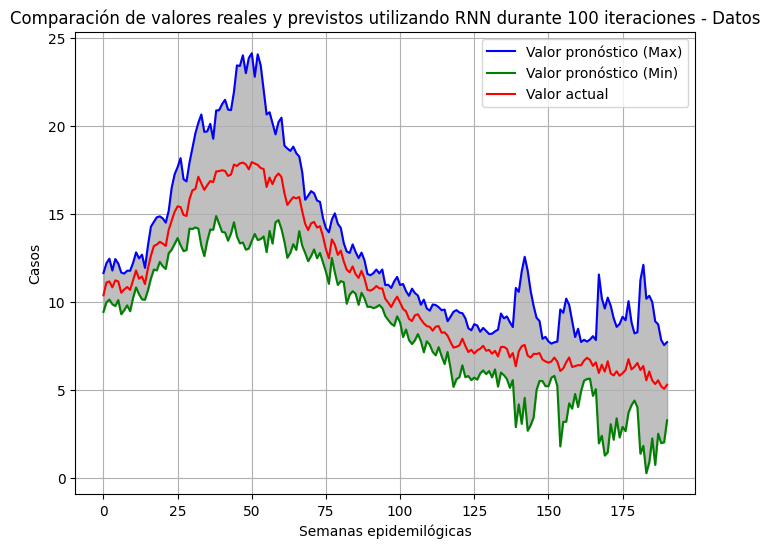

In [280]:
temp = pd.read_excel('RNN_PREDICT.xlsx')
shade_plot(temp, line='RNN', predict='YES')

**LSTM**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

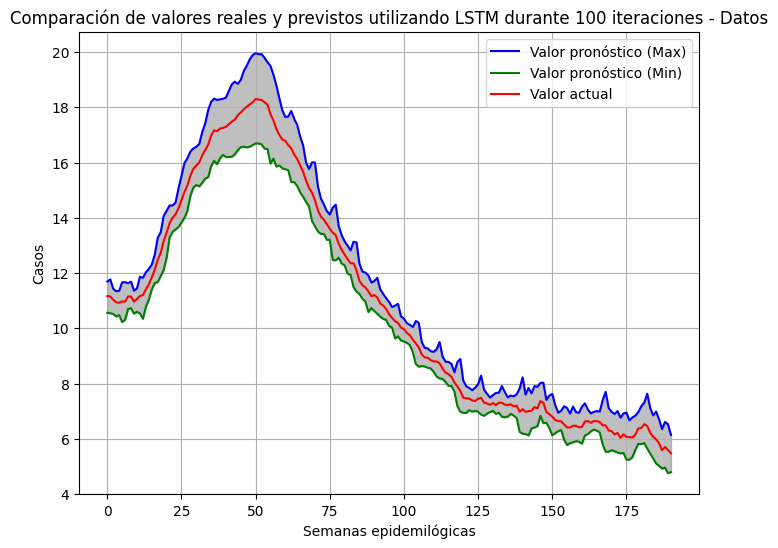

In [281]:
temp = pd.read_excel('LSTM_PREDICT.xlsx')
shade_plot(temp, line='LSTM', predict='YES')

**GRU**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

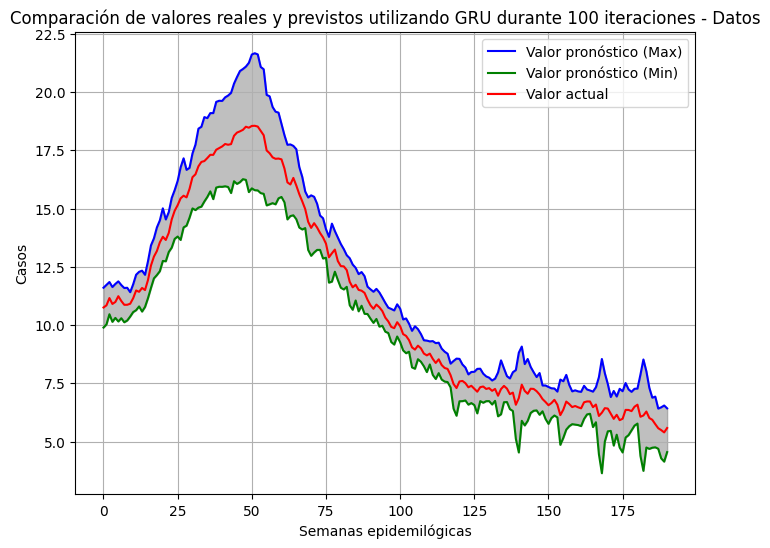

In [282]:
temp = pd.read_excel('GRU_PREDICT.xlsx')
shade_plot(temp, line='GRU', predict='YES')

In [283]:
!gdown 1Jcj7_vtMQ2foct0YPmWC6nO9q4T_x3bl
!gdown 1d-M7kCjRcggRBII-8o9WUhbWPaFxcPRg

Downloading...
From: https://drive.google.com/uc?id=1Jcj7_vtMQ2foct0YPmWC6nO9q4T_x3bl
To: /content/RNN_LSTM_PREDICT.xlsx
100% 230k/230k [00:00<00:00, 5.15MB/s]
Downloading...
From: https://drive.google.com/uc?id=1d-M7kCjRcggRBII-8o9WUhbWPaFxcPRg
To: /content/RNN_LSTM_LOSS.xlsx
100% 127k/127k [00:00<00:00, 4.16MB/s]


**RNN-LSTM**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

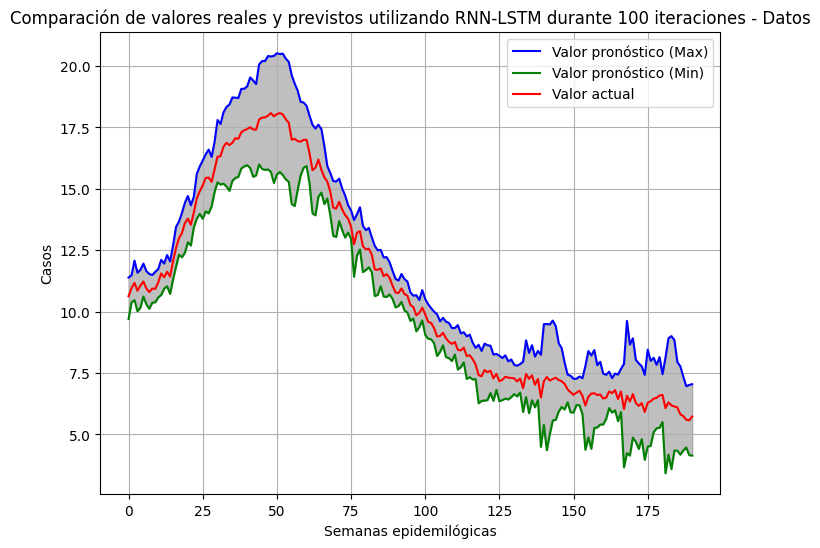

In [284]:
temp = pd.read_excel('RNN_LSTM_PREDICT.xlsx')
shade_plot(temp, line='RNN-LSTM', predict='YES')

**RNN-GRU**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

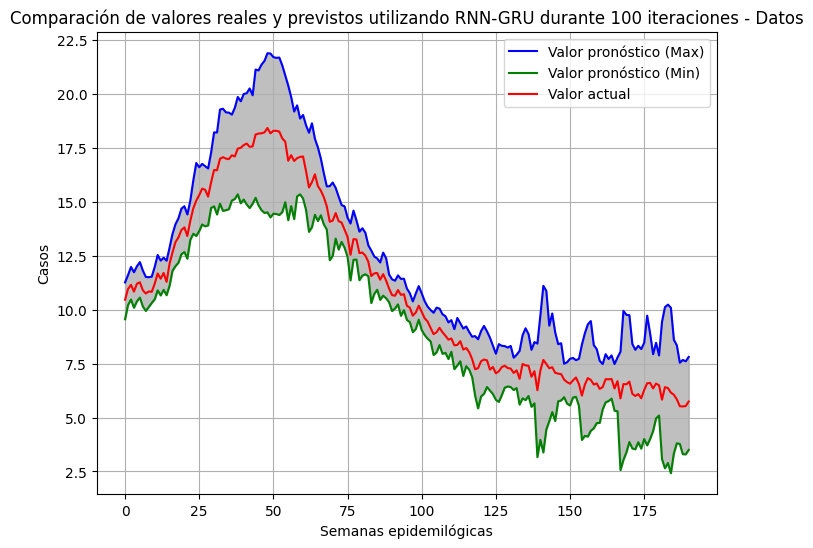

In [285]:
temp = pd.read_excel('RNN_GRU_PREDICT.xlsx')
shade_plot(temp, line='RNN-GRU', predict='YES')

**LSTM-RNN**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

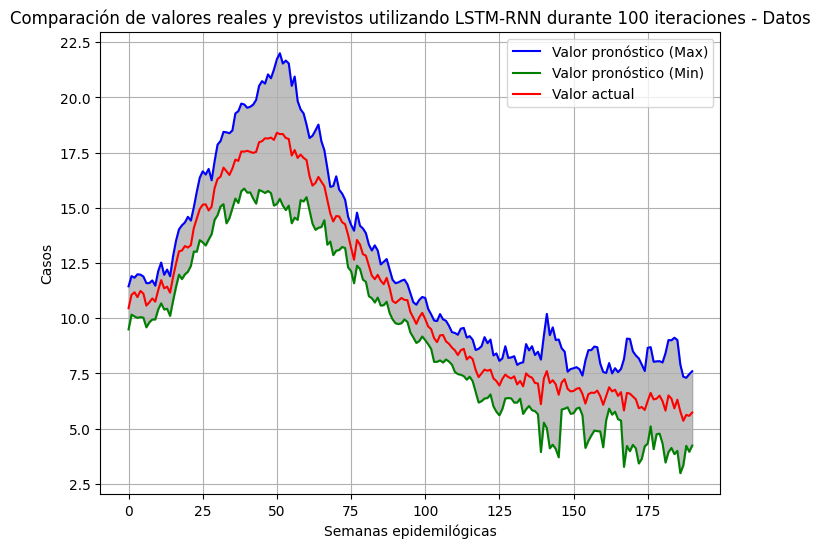

In [286]:
temp = pd.read_excel('LSTM_RNN_PREDICT.xlsx')
shade_plot(temp, line='LSTM-RNN', predict='YES')

**LSTM-GRU**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

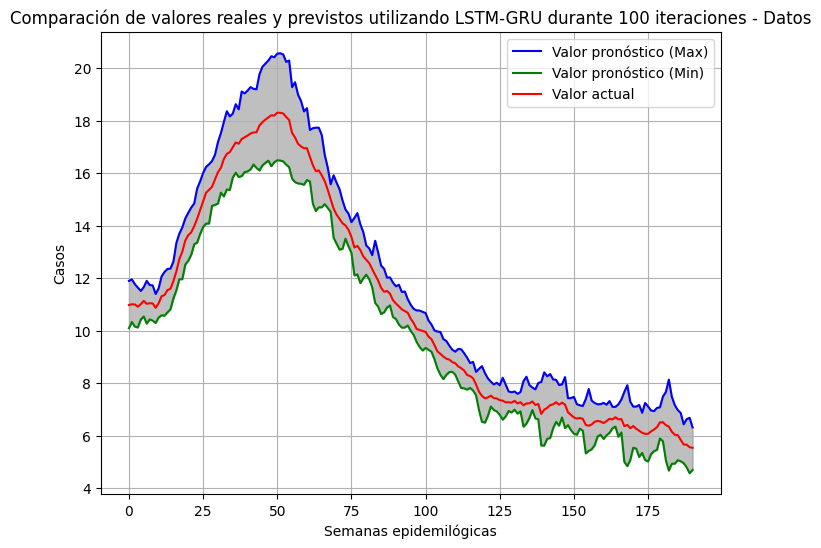

In [287]:
temp = pd.read_excel('LSTM_GRU_PREDICT.xlsx')
shade_plot(temp, line='LSTM-GRU', predict='YES')

**GRU-RNN**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

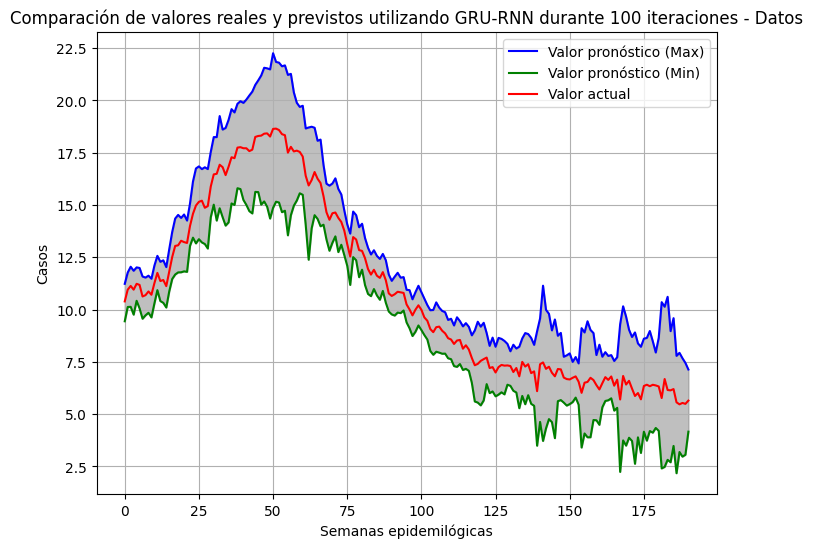

In [288]:
temp = pd.read_excel('GRU_RNN_PREDICT.xlsx')
shade_plot(temp, line='GRU-RNN', predict='YES')

**GRU-LSTM**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

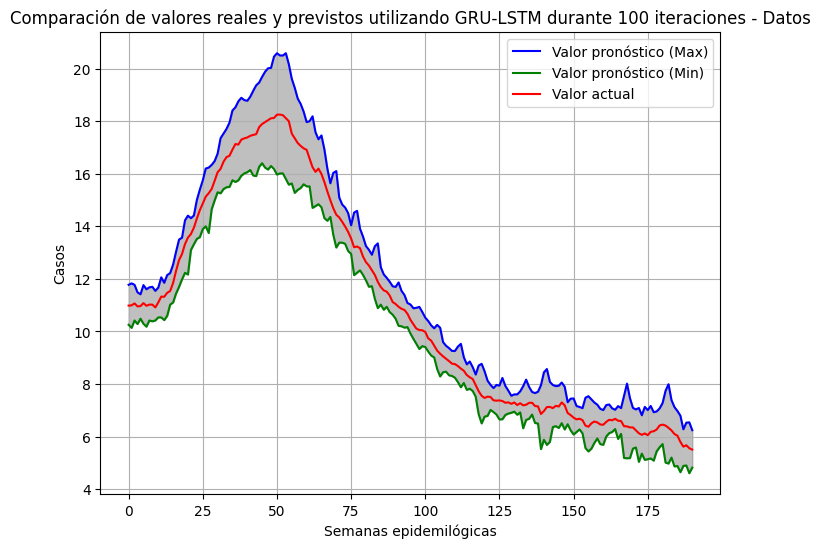

In [289]:
temp = pd.read_excel('GRU_LSTM_PREDICT.xlsx')
shade_plot(temp, line='GRU-LSTM', predict='YES')

**DONWLOAD DATA**

In [223]:
!gdown 1_Xk_aBt72cg0IhtrDHByatBuGuLi-svr
!gdown 1ZrtG6EfZxXeV19WMzla_qniBb4E0vHGp
!gdown 1YCs0hRgt-wpSVI7EbtLit5HvjM7brmtB
!gdown 194--ZfpP3lr5eg8jfjbDLSWDSvWVVx18
!gdown 1mrYem8IETC1Bvv4XLfkuFc_Yxs0L-1M5
!gdown 11ElHC2LM013wujQwqW12SD6gDrv60mOl
!gdown 1f62wFr9ML2AAO39aeU2dbKsmh3idLyOi
!gdown 1EImqlbcinVzjSxp5wM27YfCo9Nf_YBn0

Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1_Xk_aBt72cg0IhtrDHByatBuGuLi-svr

but Gdown can't. Please check connections and permissions.
Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1ZrtG6EfZxXeV19WMzla_qniBb4E0vHGp

but Gdown can't. Please check connections and permissions.
Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or

In [224]:
!gdown 1NyWC6xVK2tlvtjcx0xv8I4O_bI0KebdS
!gdown 1UFgEoC6-313M_dpjq7mW9LICaUvbkoNa
!gdown 1vuERyAz3ckNgg_vAAcjznPa7jpNJN9Rt
!gdown 1ZumVvaJpYdkWhSKZNlqbrHzi--A3iwtx
!gdown 1z0qcyj5D7XoZ4bTMDZ3yaOuHaFaqmXSZ
!gdown 16dF5YhHT4R_g5HbdAsO_cEXejJQ87Pg2
!gdown 1DLTaT7OQxd_R71nSjjj7r7NSJfkG0X8X
!gdown 1A1ARznJ4X2xQM5AL05yfhZo6KIQ21rxZ
!gdown 1fvzFbPqCzqdoLujlHxqIqNlnuCRPddTV
!gdown 1avI3Q59EZV92abBlLrSjNYG05ndLcOJ9
!gdown 16ZR-PaPNwqSyzFj-0SS8AqB7xIJ4OrYe
!gdown 1SgjgWPVq-QTgva1OFAZNKrVzQr0aJwRr
!gdown 1b1zT-srRQd1PEmXi2MyhojUFTGhPTHBM
!gdown 1zsmjBebdjFhh-tm8V4zPF9rQDKs76Vyv
!gdown 1raNErRqrAcr5qFCXH2T1G4bqhbu6l-m5
!gdown 1MHL7n1sIjWsouMWbYfgvDLud-Ba6wWM1
!gdown 1FblK2jeAC9kkZsRp9I6o-64Uqtpql-XI
!gdown 1n718TN1i5kwMEIm0Q6NTcz94D34YXgpA
!gdown 1oy-KECRHSE07R7-78D1tBdiJNbEoxI8E
!gdown 19--phk8Mf1z4QX464ZV_wVL4hfyQmSW1
!gdown 1-JzfQA2dQJe-mXrEK7fdNY1HluF_wSHQ
!gdown 16NiUOKZgspf09ztmREbffpmBKV9zBRhX
!gdown 1mb0yBP7A5seQN2naL8Sgqy54pZ5lYZAZ
!gdown 1CUxws0PZc8T_LWIKyifATBfOzFGMXBi9
!gdown 1ajESJp2rNjlmdWa31-2iIvE8lyvkGKgS
!gdown 14M9gs549r7PLS2CAjEbLoQOiaRfey6X8
!gdown 1j7YuYNeVF4Jt3F3tqG1oH4qgpGwF99jC
!gdown 1Z61vMm0J5Vjn2sNQq87FgaLbAAt8P4or

Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1NyWC6xVK2tlvtjcx0xv8I4O_bI0KebdS

but Gdown can't. Please check connections and permissions.
Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1UFgEoC6-313M_dpjq7mW9LICaUvbkoNa

but Gdown can't. Please check connections and permissions.
Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or

**Metrik Evaluation**

**MAE**

In [249]:
df1 = pd.read_excel('/content/RNN_FORECASTMae.xlsx')
df2 = pd.read_excel('/content/LSTM_FORECASTMae.xlsx')
df3 = pd.read_excel('/content/GRU_FORECASTMae.xlsx')
df4 = pd.read_excel('/content/RNN_LSTM_FORECASTMae.xlsx')
df5 = pd.read_excel('/content/RNN_GRU_FORECASTMae.xlsx')
df6 = pd.read_excel('/content/LSTM_RNN_FORECASTMae.xlsx')
df7 = pd.read_excel('/content/GRU_RNN_FORECASTMae.xlsx')
df8 = pd.read_excel('/content/LSTM_GRU_FORECASTMae.xlsx')
df9 = pd.read_excel('/content/GRU_LSTM_FORECASTMae.xlsx')
display(df1.head())

0
0  1.016681
1  1.627471
2  1.489702
3  0.887620
4  1.293666

In [250]:
df = pd.DataFrame()
df['RNN'] = df1[0]
df['LSTM'] = df2[0]
df['GRU'] = df3[0]
df['RNN_LSTM'] = df4[0]
df['RNN_GRU'] = df5[0]
df['LSTM_RNN'] = df6[0]
df['GRU_RNN'] = df7[0]
df['LSTM_GRU'] = df8[0]
df['GRU_LSTM'] = df9[0]
# n = int(len(df) * (20 / 100))
n = int(len(df) * (2.5 / 100))
df = df.iloc[n:-n]

Columns of df1: Index([0], dtype='int64')


/tmp/ipython-input-3130326054.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data.values, labels=data.columns,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

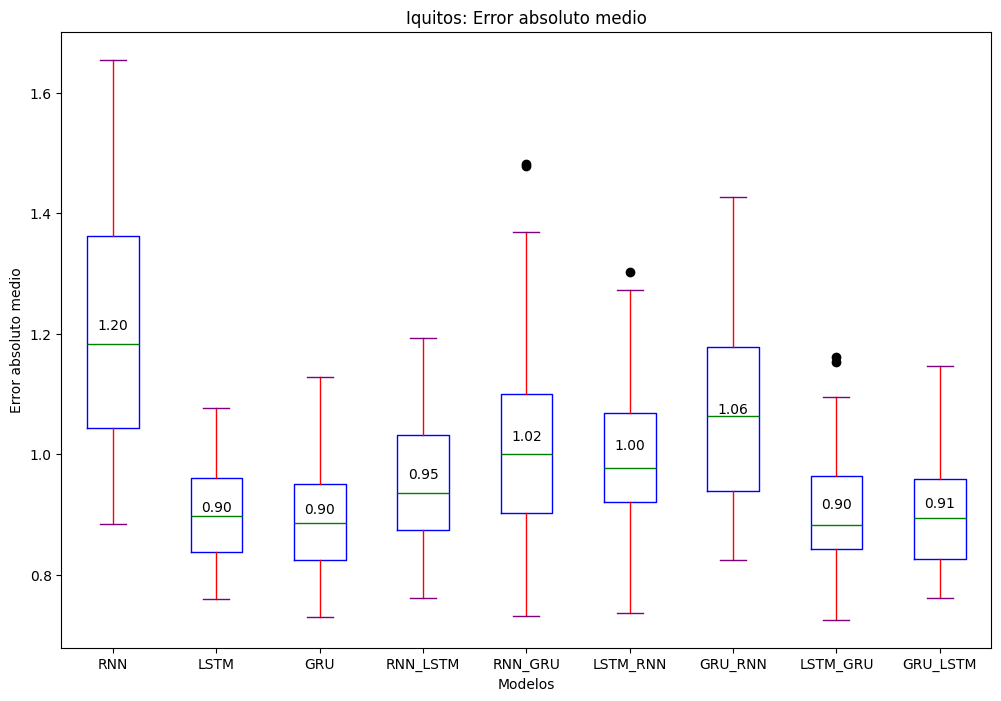

In [251]:
# n = int(len(df)*0.15)
n = int(len(df1) * 0.025)
print("Columns of df1:", df1.columns)
data = pd.DataFrame({
    'RNN': sorted(df1[0]),
    'LSTM': sorted(df2[0]),
    'GRU': sorted(df3[0]),
    'RNN_LSTM': sorted(df4[0]),
    'RNN_GRU': sorted(df5[0]),
    'LSTM_RNN': sorted(df6[0]),
    'GRU_RNN': sorted(df7[0]),
    'LSTM_GRU': sorted(df8[0]),
    'GRU_LSTM': sorted(df9[0])
}).iloc[n:-n]

box_color = 'blue'
whisker_color = 'red'
median_color = 'green'
flier_color = 'black'
cap_color = 'purple'
fig, ax = plt.subplots(figsize=(12, 8))
plt.boxplot(data.values, labels=data.columns,
boxprops=dict(color=box_color),
whiskerprops=dict(color=whisker_color),
capprops=dict(color=cap_color),
flierprops=dict(markerfacecolor=flier_color, marker='o', markersize=6),
medianprops=dict(color=median_color))
for i, column in enumerate(data.columns):
    mean = np.mean(data[column])
    plt.text(i + 1, mean, f'{mean:.2f}', ha='center', va='bottom', color='black')
plt.title('Iquitos: Error absoluto medio')
plt.xlabel('Modelos')
plt.ylabel('Error absoluto medio')
plt.savefig("Comparison_MAE_Dataset2.pdf", dpi=300)
files.download("Comparison_MAE_Dataset2.pdf")
plt.show()

In [252]:
# Calculate mean and confidence intervals for each model (using a 95% confidence level) based on filtered data
results_mae = {}
for column in data.columns:
    mean_mae = np.mean(data[column])
    std_mae = np.std(data[column])
    # Calculate 95% confidence interval (using t-distribution for small sample sizes)
    # Degrees of freedom is n-1
    n_mae = len(data[column])
    if n_mae > 1:
        t_score_mae = 2.0 # Approximate t-score for 95% CI and reasonable df, more precise calculation is possible with scipy.stats.t.ppf
        confidence_interval_mae = t_score_mae * (std_mae / np.sqrt(n_mae))
    else:
        confidence_interval_mae = float('nan') # Cannot calculate CI with only one data point

    results_mae[column] = {
        'Mean MAE': mean_mae,
        'Confidence Interval (95%)': confidence_interval_mae
    }

# Create a pandas DataFrame from the results
results_mae_df = pd.DataFrame.from_dict(results_mae, orient='index')

# Display the table
display(results_mae_df)

Mean MAE  Confidence Interval (95%)
RNN       1.202724                   0.041544
LSTM      0.900500                   0.016226
GRU       0.897113                   0.019570
RNN_LSTM  0.954771                   0.022731
RNN_GRU   1.017218                   0.031613
LSTM_RNN  1.003115                   0.023514
GRU_RNN   1.063086                   0.028703
LSTM_GRU  0.904595                   0.019233
GRU_LSTM  0.906834                   0.019136

**RMSE**

In [242]:
df1 = pd.read_excel('/content/RNN_FORECASTRMse.xlsx')
df2 = pd.read_excel('/content/LSTM_FORECASTRMse.xlsx')
df3 = pd.read_excel('/content/GRU_FORECASTRMse.xlsx')
df4 = pd.read_excel('/content/RNN-LSTM_FORECASTRMse.xlsx')
df5 = pd.read_excel('/content/RNN-GRU_FORECASTRMse.xlsx')
df6 = pd.read_excel('/content/LSTM-RNN_FORECASTRMse.xlsx')
df7 = pd.read_excel('/content/GRU-RNN_FORECASTRMse.xlsx')
df8 = pd.read_excel('/content/LSTM-GRU_FORECASTRMse.xlsx')
df9 = pd.read_excel('/content/GRU-LSTM_FORECASTRMse.xlsx')
df = pd.DataFrame()
df['RNN'] = df1['RMSE']
df['LSTM'] = df2['RMSE']
df['GRU'] = df3['RMSE']
df['RNN_LSTM'] = df4['RMSE']
df['RNN_GRU'] = df5['RMSE']
df['LSTM_RNN'] = df6['RMSE']
df['GRU_RNN'] = df7['RMSE']
df['LSTM_GRU'] = df8['RMSE']
df['GRU_LSTM'] = df9['RMSE']
# n = int(len(df) * (20 / 100))
n = int(len(df) * (2.5 / 100))
df = df.iloc[n:-n]

/tmp/ipython-input-1871021242.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data.values, labels=data.columns,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

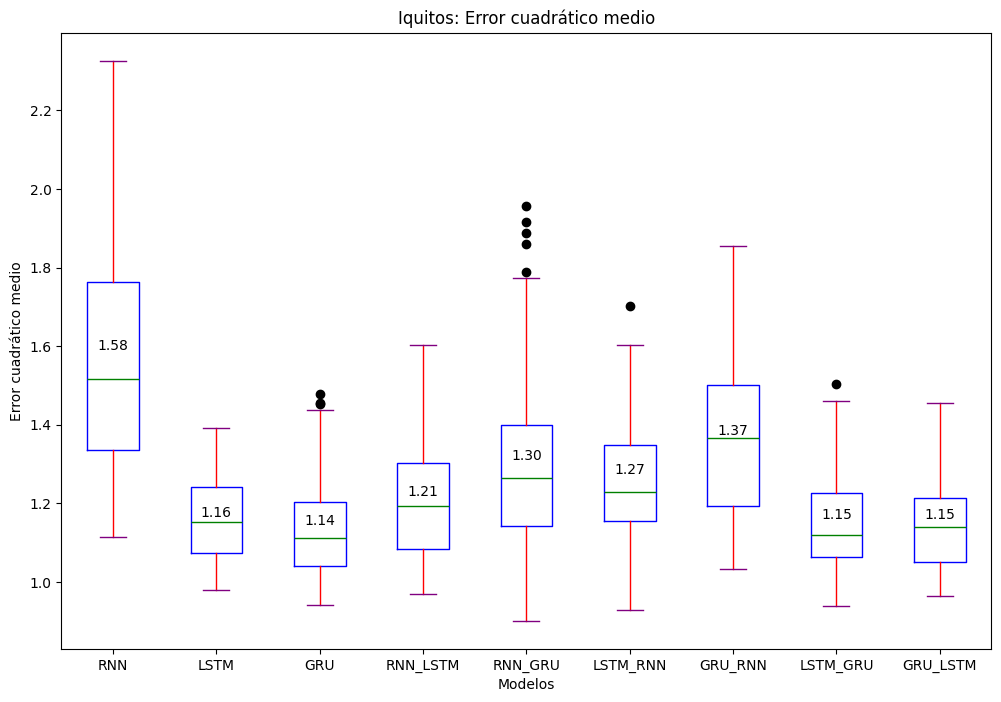

In [245]:
df = pd.DataFrame()
df['RNN'] = sorted(df1['RMSE'])
df['LSTM'] = sorted(df2['RMSE'])
df['GRU'] = sorted(df3['RMSE'])
df['RNN_LSTM'] = sorted(df4['RMSE'])
df['RNN_GRU'] = sorted(df5['RMSE'])
df['LSTM_RNN'] = sorted(df6['RMSE'])
df['GRU_RNN'] = sorted(df7['RMSE'])
df['LSTM_GRU'] = sorted(df8['RMSE'])
df['GRU_LSTM'] = sorted(df9['RMSE'])
# n = int(len(df)*0.15)
n = int(len(df) * 0.025)

df = df[:].iloc[n:-n]
data = df[:]
box_color = 'blue'
whisker_color = 'red'
median_color = 'green'
flier_color = 'black'
cap_color = 'purple'
fig, ax = plt.subplots(figsize=(12, 8))
plt.boxplot(data.values, labels=data.columns,
boxprops=dict(color=box_color),
whiskerprops=dict(color=whisker_color),
capprops=dict(color=cap_color),
flierprops=dict(markerfacecolor=flier_color, marker='o', markersize=6),
medianprops=dict(color=median_color))
for i, column in enumerate(data.columns):
    mean = np.mean(data[column])
    plt.text(i + 1, mean, f'{mean:.2f}', ha='center', va='bottom', color='black')
plt.title('Iquitos: Error cuadrático medio')
plt.xlabel('Modelos')
plt.ylabel('Error cuadrático medio')
plt.savefig("Comparison_RMSE_Dataset2.pdf", dpi=300)
files.download("Comparison_RMSE_Dataset2.pdf")
plt.show()

In [241]:
# Calculate mean and confidence intervals for each model (using a 95% confidence level) based on filtered data
results_rmse = {}
for column in data.columns:
    mean_rmse = np.mean(data[column])
    std_rmse = np.std(data[column])
    # Calculate 95% confidence interval (using t-distribution for small sample sizes)
    # Degrees of freedom is n-1
    n_rmse = len(data[column])
    if n_rmse > 1:
        t_score_rmse = 2.0 # Approximate t-score for 95% CI and reasonable df, more precise calculation is possible with scipy.stats.t.ppf
        confidence_interval_rmse = t_score_rmse * (std_rmse / np.sqrt(n_rmse))
    else:
        confidence_interval_rmse = float('nan') # Cannot calculate CI with only one data point

    results_rmse[column] = {
        'Mean RMSE': mean_rmse,
        'Confidence Interval (95%)': confidence_interval_rmse
    }

# Create a pandas DataFrame from the results
results_rmse_df = pd.DataFrame.from_dict(results_rmse, orient='index')

# Display the table
display(results_rmse_df)

Mean RMSE  Confidence Interval (95%)
RNN        1.583027                   0.062560
LSTM       1.158956                   0.022213
GRU        1.137994                   0.027276
RNN_LSTM   1.211459                   0.032226
RNN_GRU    1.302358                   0.044888
LSTM_RNN   1.267636                   0.031340
GRU_RNN    1.366056                   0.039983
LSTM_GRU   1.152648                   0.025810
GRU_LSTM   1.152763                   0.026020

**MAPE**

In [246]:
df1 = pd.read_excel('/content/RNN_FORECASTMpe.xlsx')
df2 = pd.read_excel('/content/LSTM_FORECASTMpe.xlsx')
df3 = pd.read_excel('/content/GRU_FORECASTMpe.xlsx')
df4 = pd.read_excel('/content/RNN-LSTM_FORECASTMpe.xlsx')
df5 = pd.read_excel('/content/RNN-GRU_FORECASTMpe.xlsx')
df6 = pd.read_excel('/content/LSTM-RNN_FORECASTMpe.xlsx')
df7 = pd.read_excel('/content/GRU-RNN_FORECASTMpe.xlsx')
df8 = pd.read_excel('/content/LSTM-GRU_FORECASTMpe.xlsx')
df9 = pd.read_excel('/content/GRU-LSTM_FORECASTMpe.xlsx')
df = pd.DataFrame()
df['RNN'] = df1['MAPE']
df['LSTM'] = df2['MAPE']
df['GRU'] = df3['MAPE']
df['RNN_LSTM'] = df4['MAPE']
df['RNN_GRU'] = df5['MAPE']
df['LSTM_RNN'] = df6['MAPE']
df['GRU_RNN'] = df7['MAPE']
df['LSTM_GRU'] = df8['MAPE']
df['GRU_LSTM'] = df9['MAPE']
# n = int(len(df) * (20 / 100))
n = int(len(df) * (2.5 / 100))
df = df.iloc[n:-n]

/tmp/ipython-input-2876141734.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data.values, labels=data.columns,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

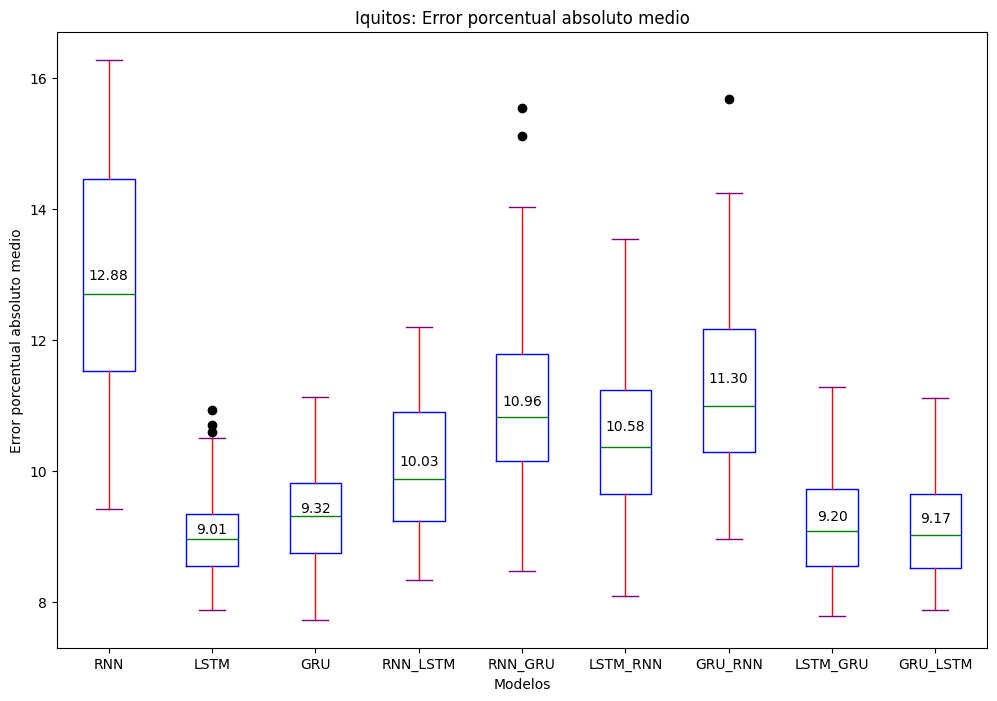

In [247]:
df = pd.DataFrame()
df['RNN'] = sorted(df1['MAPE'])
df['LSTM'] = sorted(df2['MAPE'])
df['GRU'] = sorted(df3['MAPE'])
df['RNN_LSTM'] = sorted(df4['MAPE'])
df['RNN_GRU'] = sorted(df5['MAPE'])
df['LSTM_RNN'] = sorted(df6['MAPE'])
df['GRU_RNN'] = sorted(df7['MAPE'])
df['LSTM_GRU'] = sorted(df8['MAPE'])
df['GRU_LSTM'] = sorted(df9['MAPE'])
# n = int(len(df)*0.15)
n = int(len(df) * 0.025)
df = df[:].iloc[n:-n]
data = df[:]
box_color = 'blue'
whisker_color = 'red'
median_color = 'green'
flier_color = 'black'
cap_color = 'purple'
fig, ax = plt.subplots(figsize=(12, 8))
plt.boxplot(data.values, labels=data.columns,
boxprops=dict(color=box_color),
whiskerprops=dict(color=whisker_color),
capprops=dict(color=cap_color),
flierprops=dict(markerfacecolor=flier_color, marker='o', markersize=6),
medianprops=dict(color=median_color))
for i, column in enumerate(data.columns):
    mean = np.mean(data[column])
    plt.text(i + 1, mean, f'{mean:.2f}', ha='center', va='bottom', color='black')
plt.title('Iquitos: Error porcentual absoluto medio')
plt.xlabel('Modelos')
plt.ylabel('Error porcentual absoluto medio')
plt.savefig("Comparison_MAPE_Dataset2.pdf", dpi=300)
files.download("Comparison_MAPE_Dataset2.pdf")
plt.show()

In [235]:
# Calculate mean and confidence intervals for each model (using a 95% confidence level) based on filtered data
results = {}
for column in data.columns:
    mean = np.mean(data[column])
    std = np.std(data[column])
    # Calculate 95% confidence interval (using t-distribution for small sample sizes)
    # Degrees of freedom is n-1
    n = len(data[column])
    if n > 1:
        t_score = 2.0 # Approximate t-score for 95% CI and reasonable df, more precise calculation is possible with scipy.stats.t.ppf
        confidence_interval = t_score * (std / np.sqrt(n))
    else:
        confidence_interval = float('nan') # Cannot calculate CI with only one data point

    results[column] = {
        'Mean MAPE': mean,
        'Confidence Interval (95%)': confidence_interval
    }

# Create a pandas DataFrame from the results
results_df = pd.DataFrame.from_dict(results, orient='index')

# Display the table
display(results_df)

Mean MAPE  Confidence Interval (95%)
RNN       12.877303                   0.345510
LSTM       9.007143                   0.134721
GRU        9.318913                   0.162421
RNN_LSTM  10.031364                   0.201988
RNN_GRU   10.961641                   0.269057
LSTM_RNN  10.578385                   0.250069
GRU_RNN   11.303481                   0.274403
LSTM_GRU   9.201300                   0.169939
GRU_LSTM   9.174110                   0.159279

**Time Comparison**

In [232]:
df1 = pd.read_excel('/content/RNN_TIME.xlsx')
df2 = pd.read_excel('/content/LSTM_TIME.xlsx')
df3 = pd.read_excel('/content/GRU_TIME.xlsx')
df4 = pd.read_excel('/content/RNN-LSTM_TIME.xlsx')
df5 = pd.read_excel('/content/RNN-GRU_TIME.xlsx')
df6 = pd.read_excel('/content/LSTM-RNN_TIME.xlsx')
df7 = pd.read_excel('/content/GRU-RNN_TIME.xlsx')
df8 = pd.read_excel('/content/LSTM-GRU_TIME.xlsx')
df9 = pd.read_excel('/content/GRU-LSTM_TIME.xlsx')
df = pd.DataFrame()
df['RNN'] = df1[0]
df['LSTM'] = df2[0]
df['GRU'] = df3[0]
df['RNN_LSTM'] = df4[0]
df['RNN_GRU'] = df5[0]
df['LSTM_RNN'] = df6[0]
df['GRU_RNN'] = df7[0]
df['LSTM_GRU'] = df8[0]
df['GRU_LSTM'] = df9[0]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

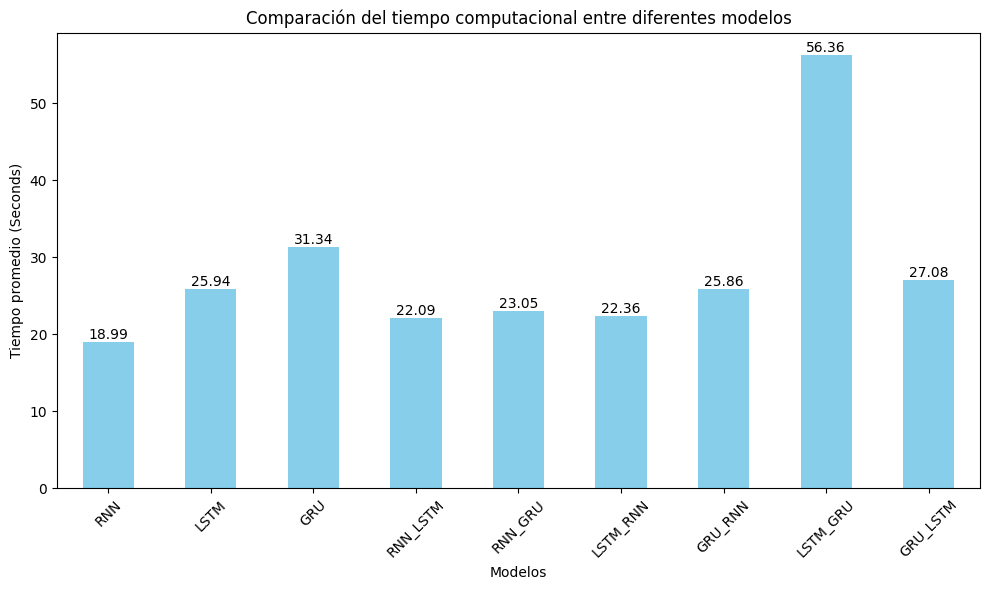

In [233]:
# Calculate the average time for each model
average_times = df.mean()
# Create a bar chart
plt.figure(figsize=(10, 6))
average_times.plot(kind='bar', color='skyblue')
plt.title('Comparación del tiempo computacional entre diferentes modelos')
plt.xlabel('Modelos')
plt.ylabel('Tiempo promedio (Seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
# Display the average times on top of the bars
for i, v in enumerate(average_times):
    plt.text(i, v, f"{v:.2f}", ha='center', va='bottom')
plt.savefig("Comparison_Time_Dataset2.pdf", dpi=300)
files.download("Comparison_Time_Dataset2.pdf")
plt.show()